In [1]:
import os
import pandas as pd
import numpy as np

from datetime import datetime

from pandas.tseries.offsets import MonthEnd

from matplotlib import pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')


In [ ]:
data_path = "/Users/ksachdeva/Downloads/claim_freq_data/"
claims_raw = pd.read_csv(f"{data_path}claims_raw-sept.csv")
billing_summary = pd.read_csv(f"{data_path}billing_summary.csv")
opportunities = pd.read_csv(f"{data_path}unique_dot_opportunity.csv")
monthly_billing_raw = pd.read_csv(f"{data_path}billed-mileage.csv")
ep_monthly_raw = pd.read_csv(f"{data_path}ep-monthly.csv")
policies = pd.read_csv(f"{data_path}policies.csv")
gsa = pd.read_csv(f"{data_path}gsa.csv")
opportunities = pd.read_csv(f"{data_path}unique_dot_opportunity.csv")
at_fault_claims_summary = pd.read_csv(f"{data_path}model___at_faults_claims_summary_2024-11-22T10_55_06.143828Z.csv")

In [2]:
data_path = "/Users/ksachdeva/Downloads/claim_freq_data/"
print(data_path)
# billing_path = "/Users/abhi/Work/Projects/claim_frequency_analysis/v2/"
default_rubric_path = f"{data_path}/default_rubric_version.csv"
app_trs_path = f"{data_path}/Application_risk_score_rubrics_9_Dec_2024.csv"
# nirvana_claims_path = f"{data_path}/claims_data_gsheet.csv"
# monthly_billing_path = f"{data_path}/billed_mileage_monthly.csv"
# ep_monthly_path = f"{data_path}/ep_monthly.csv"
# appetite_score_path = f"{data_path}/appetite_score.csv"
app_appetite_path = f"{data_path}/all_apps_appetite.csv"

trs_launch_date = datetime(2023, 12, 1)
print(f"trs_launch_date: {trs_launch_date}")


/Users/ksachdeva/Downloads/claim_freq_data/
trs_launch_date: 2023-12-01 00:00:00


## Application TRS

In [3]:
def get_valid_apps_trs(app_trs_data, default_rubric_version, trs_launch_date, only_bound=True):
    print(len(app_trs_data))

    # Keep only fleet accounts
    app_trs_data = app_trs_data[app_trs_data['Application Source']=='Fleet']
    print(len(app_trs_data))

    # Add default rubric version
    app_trs_data = app_trs_data.merge(default_rubric_version, how='left')
    print(len(app_trs_data))

    # Remove invalid rubric versions
    app_trs_data['is_valid_rubric'] = app_trs_data['Rubric Version'] == app_trs_data['Default Rubric Version']
    app_trs_data = app_trs_data[app_trs_data['is_valid_rubric']]

    if only_bound:
        app_trs_data = app_trs_data[app_trs_data['Is Bound']==1]
    
    # appetite_score = pd.read_csv(appetite_score_path)
    # app_trs_data = app_trs_data.merge(appetite_score, how='left', on='Application ID')

    app_trs_data['Effective Date'] = pd.to_datetime(app_trs_data['Effective Date'], errors='coerce')
    app_trs_data['Pre_TRS'] = np.where(app_trs_data['Effective Date'] < trs_launch_date, True, False)
    
    return app_trs_data

In [4]:
def get_recommended_action(trs_segment, appetite_score):
    if trs_segment == "Decline":
        return "Decline"
    elif trs_segment == "Extended":
        if appetite_score == "HighRisk":
            return "Decline"
        if appetite_score in ["Marginal", "Acceptable"]:
            return "Neutral"
        if appetite_score == "Preferred":
            return "Quote"
    elif trs_segment == "Acceptable":
        if appetite_score == "HighRisk":
            return "Decline"
        if appetite_score == "Marginal":
            return "Neutral"
        if appetite_score == "Acceptable":
            return "Quote"
        if appetite_score == "Preferred":
            return "Strongly Quote"
    elif trs_segment == "Target":
        if appetite_score == "HighRisk":
            return "Neutral"
        if appetite_score == "Marginal":
            return "Quote"
        if appetite_score in ["Acceptable", "Preferred"]:
            return "Strongly Quote"
    else:
        if appetite_score in ["HighRisk", "Marginal"]:
            return "Decline"
        if appetite_score == "Acceptable":
            return "Neutral"
        if appetite_score == "Preferred":
            return "Quote"

In [5]:
default_rubric_version = pd.read_csv(default_rubric_path)
default_rubric_version.head()

Score Type  Version Default Rubric Version
0     NF TRS      1.0                     V1
1        TRS      3.0                     V2
2        TRS      3.1                     V2
3        TRS      4.0                     V2
4   Milliman      0.0                     M1

In [6]:
app_trs_data = pd.read_csv(app_trs_path)
app_trs_data.head(3)

Application ID                         Connection ID  \
0  b1d8d7f0-dac2-4095-943a-432e9d18673f  651fd9a5-73f8-4d75-a921-ce63f6d0f5f3   
1  b1d8d7f0-dac2-4095-943a-432e9d18673f  651fd9a5-73f8-4d75-a921-ce63f6d0f5f3   
2  b1d8d7f0-dac2-4095-943a-432e9d18673f  651fd9a5-73f8-4d75-a921-ce63f6d0f5f3   

               Score Type  Version    Start Date         End Date  \
0  NF GPS Only 10-sec TRS      1.0  July 1, 2024  October 1, 2024   
1  NF GPS Only 10-sec TRS      1.0  July 1, 2024  October 1, 2024   
2  NF GPS Only 10-sec TRS      1.0  July 1, 2024  October 1, 2024   

  Application Source  Dot Number     Effective Date    Tsp Enum  ...  \
0          Non-Fleet     3350889  November 26, 2024  TSPSamsara  ...   
1          Non-Fleet     3350889  November 26, 2024  TSPSamsara  ...   
2          Non-Fleet     3350889  November 26, 2024  TSPSamsara  ...   

  Is Review Score  Is Latest Score  Window Tag  Rubric Version Segment ID  \
0            True             True   at_review              V1         10   
1            True             True   at_review              V2         10   
2            True             True   at_review              V3         10   

   Segment  Lo   Hi Is Market Discount ($)  
0   Target  90  100      True         -0.2  
1   Target  90  100      True         -0.2  
2   Target  90  100      True         -0.1  

[3 rows x 34 columns]

In [7]:
app_trs_data["Recommended_Action"] = app_trs_data.apply(lambda x: get_recommended_action(x["Segment"], x["Appetite Score"]), axis=1)
app_trs_data["Recommended_Action"].value_counts()

Decline           67527
Neutral           18914
Strongly Quote    17134
Quote             14939
Name: Recommended_Action, dtype: int64

In [8]:
valid_app_trs_data = get_valid_apps_trs(app_trs_data, default_rubric_version, trs_launch_date, only_bound=False)
# valid_app_trs_data.to_csv(f"{data_path}/valid_app_trs_data.csv", index=False)

134936
106136
106136


In [9]:
valid_app_trs_data[valid_app_trs_data['Score Type Version']=='TRS 4.0'].groupby(['Pre_TRS'])['Segment'].value_counts(normalize=True)

Pre_TRS  Segment   
False    Acceptable    0.302228
         Target        0.293175
         Extended      0.208914
         Decline       0.195682
True     Decline       0.312899
         Acceptable    0.283525
         Extended      0.219668
         Target        0.183908
Name: Segment, dtype: float64

In [10]:
bound_app_trs_data = get_valid_apps_trs(app_trs_data=app_trs_data, default_rubric_version=default_rubric_version, trs_launch_date=trs_launch_date, only_bound=True)
bound_app_trs_data.head()

134936
106136
106136


Application ID  \
58   c9e9b2c6-4383-4b88-b534-e924c6b499c5   
129  f6c7a171-f8c0-4f22-a532-b2a48e84bcdb   
209  f6c7a171-f8c0-4f22-a532-b2a48e84bcdb   
321  faae0ddc-f0ed-4eb3-a609-62c2ed02b3f5   
409  2d49c36f-f92f-41aa-8910-9b8a90017de7   

                            Connection ID          Score Type  Version  \
58   bc1e901c-649d-4d7c-b9b6-e556b201b607  GPS Only 1-min TRS      3.1   
129  f5ea8077-6b8a-4b76-a6c6-91fbcd6f2d94                 TRS      4.0   
209  f5ea8077-6b8a-4b76-a6c6-91fbcd6f2d94                 TRS      3.1   
321  dee646a6-411d-4a9b-996a-5e624330a902                 TRS      3.1   
409  be439d99-d5ae-4899-822a-a953d4d92aef                 TRS      4.0   

           Start Date          End Date Application Source  Dot Number  \
58   November 1, 2023  February 1, 2024              Fleet     2565724   
129       May 1, 2023    August 1, 2023              Fleet     1987062   
209       May 1, 2023    August 1, 2023              Fleet     1987062   
321    August 1, 2023  November 1, 2023              Fleet     3555834   
409     April 1, 2022      July 1, 2022              Fleet     3022897   

    Effective Date        Tsp Enum  ... Segment ID     Segment  Lo  Hi  \
58      2024-03-01      TSPSamsara  ...          8  Acceptable  70  80   
129     2023-09-10  TSPKeepTruckin  ...          9      Target  80  90   
209     2023-09-10  TSPKeepTruckin  ...          2     Decline  10  20   
321     2023-11-20      TSPSamsara  ...          8      Target  70  80   
409     2022-07-25  TSPKeepTruckin  ...          4    Extended  30  40   

    Is Market  Discount ($)  Recommended_Action Default Rubric Version  \
58       True         -0.10             Neutral                     V3   
129      True         -0.10      Strongly Quote                     V2   
209     False           NaN             Decline                     V2   
321      True         -0.10      Strongly Quote                     V2   
409      True          0.05             Neutral                     V2   

    is_valid_rubric Pre_TRS  
58             True   False  
129            True    True  
209            True    True  
321            True    True  
409            True    True  

[5 rows x 38 columns]

In [11]:
bound_app_trs_data['Recommended_Action'].value_counts()

Decline           519
Strongly Quote    500
Neutral           494
Quote             428
Name: Recommended_Action, dtype: int64

In [12]:
vin_count_data = pd.read_csv(app_appetite_path)
vin_count_data = vin_count_data[['Application ID', 'Power Units']].drop_duplicates(subset=['Application ID'])
print(f"Length of vin count data: {len(vin_count_data)}")

evaluation_data = valid_app_trs_data.merge(vin_count_data, how='inner', on='Application ID')
print(f"Length of evaluation data after merging vin count data: {len(evaluation_data)}")

evaluation_data['Segment'] = evaluation_data['Segment'].map(segment_map)

bins = [0, 30, float('inf')]
labels = ['1-30','30+']

# Create a new column 'Power Units Bucket' with bucketized values
evaluation_data['Power Units Bucket'] = pd.cut(evaluation_data['Power Units'].astype(float), bins=bins, labels=labels, right=False)
evaluation_data = evaluation_data[(evaluation_data['Score Type']=='TRS') & (evaluation_data['Version']==4.0)]
evaluation_data.columns

Length of vin count data: 13279
Length of evaluation data after merging vin count data: 13057


NameError: name 'segment_map' is not defined

In [71]:
dfx = evaluation_data.groupby(['Pre_TRS','Power Units Bucket', 'Segment']).agg({'Application ID':'count'}).reset_index()
dfx['total_apps'] = dfx.groupby(['Pre_TRS','Power Units Bucket'])['Application ID'].transform('sum')
dfx['percentage'] = (dfx['Application ID']/dfx['total_apps'])*100
dfx

Pre_TRS Power Units Bucket       Segment  Application ID  total_apps  \
0     False               1-30      0-Target             279        1055   
1     False               1-30  1-Acceptable             321        1055   
2     False               1-30    2-Extended             226        1055   
3     False               1-30     3-Decline             229        1055   
4     False                30+      0-Target             131         358   
5     False                30+  1-Acceptable             107         358   
6     False                30+    2-Extended              71         358   
7     False                30+     3-Decline              49         358   
8      True               1-30      0-Target             100         599   
9      True               1-30  1-Acceptable             159         599   
10     True               1-30    2-Extended             140         599   
11     True               1-30     3-Decline             200         599   
12     True                30+      0-Target              44         177   
13     True                30+  1-Acceptable              63         177   
14     True                30+    2-Extended              32         177   
15     True                30+     3-Decline              38         177   

    percentage  
0    26.445498  
1    30.426540  
2    21.421801  
3    21.706161  
4    36.592179  
5    29.888268  
6    19.832402  
7    13.687151  
8    16.694491  
9    26.544240  
10   23.372287  
11   33.388982  
12   24.858757  
13   35.593220  
14   18.079096  
15   21.468927

In [75]:
dfx = evaluation_data.groupby(['Pre_TRS', 'Is Renewal', 'Segment']).agg({'Is Quoted':'mean'}).reset_index()
dfx

Pre_TRS  Is Renewal       Segment  Is Quoted
0     False         0.0      0-Target   0.313514
1     False         0.0  1-Acceptable   0.259358
2     False         0.0    2-Extended   0.196970
3     False         0.0     3-Decline   0.072289
4     False         1.0      0-Target   0.725000
5     False         1.0  1-Acceptable   0.574074
6     False         1.0    2-Extended   0.818182
7     False         1.0     3-Decline   0.758621
8      True         0.0      0-Target   0.394366
9      True         0.0  1-Acceptable   0.363208
10     True         0.0    2-Extended   0.419753
11     True         0.0     3-Decline   0.253394
12     True         1.0      0-Target   1.000000
13     True         1.0  1-Acceptable   0.800000
14     True         1.0    2-Extended   0.900000
15     True         1.0     3-Decline   0.823529

In [ ]:
dfx = evaluation_data.groupby(['Pre_TRS', 'Segment', 'Is Quoted']).agg({'Is Quoted':'mean'}).reset_index()
dfx

## Claims Data

In [21]:
claims_data_paths = {
    # "AL": f"{data_path}/Application_Level_AL_claims.csv",
    "AL": f"{data_path}/application_abhi_al_dec.csv",
    #"APD": f"{data_path}/Application_Level_APD_claims.csv",
}

def get_projected_claims_data(coverage_type):
    print(f"Reading claims data for {coverage_type}")
    if coverage_type not in claims_data_paths:
        raise ValueError("Invalid coverage type")
    
    claims_data = pd.read_csv(claims_data_paths[coverage_type])
    claims_data = claims_data.rename(columns={'projected_claims': 'Projected Claims'})
    # print(claims_data.isnull().sum())

    claims_data['Amount'].fillna(0, inplace=True)
    claims_data['Billed Month'] = pd.to_datetime(claims_data['Billed Month'], format='%Y-%m-%d')   

    if not claims_data['Mileage'].dtype == 'float64':
        claims_data['Mileage'] = claims_data['Mileage'].str.replace(',', '').astype(float)
    return claims_data

## Create Analysis Data

In [14]:
segment_map = {
    'Decline': '3-Decline',
    'Extended': '2-Extended',
    'Acceptable': '1-Acceptable',
    'Target': '0-Target',
}

appetite_map = {
    'HighRisk': '3-HighRisk',
    'Marginal': '2-Marginal',
    'Acceptable': '1-Acceptable',
    'Preferred': '0-Preferred',
}

rec_action_map = {
    'Decline': '3-Decline',
    'Neutral': '2-Neutral',
    'Quote': '1-Quote',
    'Strongly Quote': '0-Strongly Quote',
}

def get_trs_combined_data(claims_data, app_trs_data, score_type, score_version, filt_score=True):
    app_trs_data = app_trs_data[
        [
            'Application ID', 'Connection ID', 'Effective Date', 'Tsp Enum', 'Is Quoted', 'Is Renewal', 'Is Bound',
            'Score Type', 'Version', 'Start Date', 'End Date', 'Vin Count', 'Score', 'Days To Effective', 'Segment', 'Appetite Score', 'Pre_TRS', 'Recommended_Action'
        ]
    ]

    app_trs_data['Segment'] = app_trs_data['Segment'].map(segment_map)
    app_trs_data['Appetite Score'] = app_trs_data['Appetite Score'].map(appetite_map)
    app_trs_data['Recommended_Action'] = app_trs_data['Recommended_Action'].map(rec_action_map)
    if filt_score:
        app_trs_data = app_trs_data[(app_trs_data['Score Type'] == score_type) & (app_trs_data['Version'] == score_version)]
    else:
        # Keep unique row for each application id
        app_trs_data = app_trs_data.drop_duplicates(subset=['Application ID', 'Connection ID', 'Effective Date', 'Tsp Enum', 'Is Quoted', 'Is Renewal', 'Is Bound', 'Appetite Score'])

    print(app_trs_data.shape)
    evaluation_data = app_trs_data.merge(claims_data, how='inner', on='Application ID')
    print(f"Length of evaluation data after merging valid app trs data: {len(evaluation_data)}")

    vin_count_data = pd.read_csv(app_appetite_path)
    vin_count_data = vin_count_data[['Application ID', 'Power Units']].drop_duplicates(subset=['Application ID'])
    print(f"Length of vin count data: {len(vin_count_data)}")

    evaluation_data = evaluation_data.merge(vin_count_data, how='left', on='Application ID')
    print(f"Length of evaluation data after merging vin count data: {len(evaluation_data)}")

    bins = [0, 30, float('inf')]
    labels = ['1-30','30+']

    # Create a new column 'Power Units Bucket' with bucketized values
    evaluation_data['Power Units Bucket'] = pd.cut(evaluation_data['Power Units'].astype(float), bins=bins, labels=labels, right=False)
    
    evaluation_data['effective_year'] = evaluation_data['Effective Date'].dt.year
    evaluation_data['effective_month'] = evaluation_data['Effective Date'].dt.to_period('M').astype('str')
    evaluation_data['effective_quarter'] = evaluation_data['Effective Date'].dt.to_period('Q').astype('str')
    evaluation_data['effective_year_half'] = (
        evaluation_data['Effective Date'].dt.year.astype(str) + "H" + evaluation_data['Effective Date'].dt.month.gt(6).add(1).astype(str)
    )

    return evaluation_data

def generate_summary_stats(
        cut_off_date, 
        app_trs_data, 
        score_type="TRS", 
        score_version=4.0, 
        coverage_type="AL", 
        claim_count_col='Claim Count', 
        projected_claim_col='Projected Claims', 
        granularity=None, 
        x_axis = 'Segment', 
        filt_score=True,
    ):
    print(f"Generating summary stats for {coverage_type}")

    claims_data = get_projected_claims_data(coverage_type)
    trs_combined_data = get_trs_combined_data(claims_data, app_trs_data, score_type, score_version, filt_score=filt_score)

    index_cols = [x_axis]

    if granularity is not None:
        index_cols = [granularity] + index_cols

    summary = trs_combined_data[
        trs_combined_data['Billed Month'] < cut_off_date
        ].pivot_table(
        index=index_cols, 
        values=['Application ID' ,'Mileage', 'Amount', claim_count_col, projected_claim_col], 
        aggfunc=np.sum
    )

    summary = trs_combined_data[
        trs_combined_data['Billed Month'] < cut_off_date
        ].groupby(index_cols).agg({'Application ID':'nunique', 'Mileage':np.sum, 'Amount': np.sum, claim_count_col: np.sum, projected_claim_col: np.sum})

    # print(summary.head())

    summary['Claim Frequency'] = ((summary[claim_count_col] / summary['Mileage']) * 1e6).round(2)
    summary['Projected Claim Frequency'] = ((summary[projected_claim_col] / summary['Mileage']) * 1e6).round(2)
    summary['Claim/EP'] = ((summary[claim_count_col] / summary['Amount']) * 1e5).round(2)
    summary['Projected_Claim/EP'] = ((summary[projected_claim_col] / summary['Amount']) * 1e5).round(2)

    return trs_combined_data, summary

In [15]:
def plot_claim_frequency(plot_data, x_axis='Segment', title="", figsize=(14, 8), coverage_type='AL', show_ep=True):
    fig, ax1 = plt.subplots(figsize=figsize)

    plot_data['Mileage'] = (plot_data['Mileage'] / 1e6).round(2)

    avg_claim_freq = ((plot_data['Projected Claims'].sum() / plot_data['Mileage'].sum())).round(2)
    avg_claim_ep = ((plot_data['Projected Claims'].sum() / plot_data['Amount'].sum()) * 1e5).round(2)

    # Plotting Claim Frequency and Projected Claim Frequency on the left y-axis
    ax1.set_xlabel(x_axis)
    ax1.set_ylabel('Mileage (in Million Miles)', color='tab:blue')
    ax1.bar(plot_data.index.get_level_values(x_axis), plot_data['Mileage'], color='lightblue', alpha=0.5, label='Mileage')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Creating a second y-axis for MILEAGE
    ax2 = ax1.twinx()

    ax2.set_ylabel('Claim Frequency', color='black')
    if show_ep:
        ax2.plot(plot_data.index.get_level_values(x_axis), plot_data['Projected_Claim/EP'], color='tab:green', marker='o', label='Projected Claim/EP($100K)')
        ax2.hlines(avg_claim_ep, 0, len(plot_data) - 1, colors='tab:green', linestyles='dashed', label=f'Mean Proj Claim/EP($100K): {avg_claim_ep}')
    
    ax2.plot(plot_data.index.get_level_values(x_axis), plot_data['Projected Claim Frequency'], color='tab:orange', marker='o', label='Projected Claim/Mile(1M)')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.hlines(avg_claim_freq, 0, len(plot_data) - 1, colors='tab:orange', linestyles='dashed', label=f'Mean Proj Claim/Mile(1M): {avg_claim_freq}')

    # Annotations for bar chart and line plot
    dfx = plot_data.reset_index()
    dfx = dfx.set_index(x_axis)
    for idx, row in dfx.iterrows():
        ax1.text(
            x=idx,
            y=(row["Mileage"] - (plot_data['Mileage'].max() / 10)),  # Slightly below the bar
            s=f'{row["Application ID"]:.0f} Accounts\n{row["Claim Count"]:.0f} Claims',
            ha="center",
            fontsize=10,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3", alpha=0.8)
        )

    # Adding legends to each axis separately (optional)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Adding title
    plt.title(title)


def plot_multi_level_claim_frequency(summary, granularity, x_axis, title="", figsize=(14, 8)):
    # Unstack the summary dataframe to get a 2D representation for Mileage and Projected Claim Frequency
    mileage_data = summary['Mileage'].unstack(level=granularity)
    mileage_data = (mileage_data / 1e6).round(2)
    claim_freq_data = summary['Projected Claim Frequency'].unstack(level=granularity)

    # Plot the data
    fig, ax1 = plt.subplots(figsize=figsize)

    # Plot Mileage as bars on the left y-axis
    mileage_data.plot(kind='bar', ax=ax1, position=0.5, width=0.4, color=['forestgreen', 'slateblue', 'orange', 'salmon'], alpha=0.3)
    ax1.set_xlabel(x_axis)
    ax1.set_ylabel('Mileage (in Million Miles)')
    ax1.tick_params(axis='y')

    ax1.set_xticklabels(ax1.get_xticks(), rotation=0)

    # Create a second y-axis for Projected Claim Frequency
    ax2 = ax1.twinx()
    claim_freq_data.plot(kind='line', ax=ax2, marker='o', linewidth=2, color=['green', 'slateblue', 'orange', 'salmon'])
    ax2.set_ylabel('Projected Claim/Mile(1M)')
    ax2.tick_params(axis='y')

    # Adding title and legend
    plt.title(title)
    ax1.legend(loc='upper left', title='Mileage')
    ax2.legend(loc='upper right', title='Projected Claim/Mile(1M)')

def plot_heatmap_claim_frequency(summary, granularity, x_axis, title="", figsize=(12, 6)):
    # Pivot the summary dataframe to get 'Appetite Score' as columns and 'Segment' as index
    heatmap_data = summary['Projected Claim Frequency'].unstack(level=granularity)

    # heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]

    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt=".2f")
    plt.xlabel(granularity)
    plt.ylabel(x_axis)

    # Adding title
    plt.title(title)

def plot_heatmap_app_count(summary, granularity, x_axis, title="", figsize=(12, 6)):
    # Pivot the summary dataframe to get 'Appetite Score' as columns and 'Segment' as index
    heatmap_data = summary['Application ID'].unstack(level=granularity) / summary['Application ID'].unstack(level=granularity).sum()

    # heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]

    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt=".2f")
    plt.xlabel(granularity)
    plt.ylabel(x_axis)

    # Adding title
    plt.title(title)

## Plots by Appetite Score X TRS v4

In [16]:
score_type = "TRS"
score_version = 4.0

coverage_type = 'AL'

# coverage_type = 'APD'
x_axis = 'Segment'
granularity = 'Appetite Score'

cut_off_date = pd.to_datetime("2024-10-01")

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=bound_app_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    x_axis=x_axis,
    granularity=granularity,
)

summary

Generating summary stats for AL
Reading claims data for AL
(321, 18)
Length of evaluation data after merging valid app trs data: 2485
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 2485


Application ID      Mileage      Amount  \
Appetite Score Segment                                                 
0-Preferred    0-Target                  27  49879736.00  3684491.11   
               1-Acceptable              31  54826469.00  4672309.74   
               2-Extended                19  21688476.00  1741884.73   
               3-Decline                  8   5875946.00   495520.76   
1-Acceptable   0-Target                  27  35171279.50  3464762.85   
               1-Acceptable              30  38226022.82  3181297.00   
               2-Extended                23  23676664.83  2331203.56   
               3-Decline                 17  19323277.00  2096590.94   
2-Marginal     0-Target                  15  28919223.00  2702251.67   
               1-Acceptable              20  40488615.00  3485940.46   
               2-Extended                21  31560353.59  3138488.82   
               3-Decline                 20  20517284.00  1862320.14   
3-HighRisk     0-Target                   7   9220310.00   793993.82   
               1-Acceptable               5  13119650.00  1038663.30   
               2-Extended                 8   6872499.00   684808.57   
               3-Decline                  5  13806588.00   847383.73   

                             Claim Count  Projected Claims  Claim Frequency  \
Appetite Score Segment                                                        
0-Preferred    0-Target               53             55.13             1.06   
               1-Acceptable           65             68.30             1.19   
               2-Extended             28             28.50             1.29   
               3-Decline              10             10.07             1.70   
1-Acceptable   0-Target               31             31.85             0.88   
               1-Acceptable           46             46.17             1.20   
               2-Extended             29             29.62             1.22   
               3-Decline              35             35.57             1.81   
2-Marginal     0-Target               37             37.63             1.28   
               1-Acceptable           59             59.88             1.46   
               2-Extended             70             70.46             2.22   
               3-Decline              23             23.50             1.12   
3-HighRisk     0-Target                7              6.99             0.76   
               1-Acceptable           31             31.12             2.36   
               2-Extended             10             10.71             1.46   
               3-Decline              12             12.06             0.87   

                             Projected Claim Frequency  Claim/EP  \
Appetite Score Segment                                             
0-Preferred    0-Target                           1.11      1.44   
               1-Acceptable                       1.25      1.39   
               2-Extended                         1.31      1.61   
               3-Decline                          1.71      2.02   
1-Acceptable   0-Target                           0.91      0.89   
               1-Acceptable                       1.21      1.45   
               2-Extended                         1.25      1.24   
               3-Decline                          1.84      1.67   
2-Marginal     0-Target                           1.30      1.37   
               1-Acceptable                       1.48      1.69   
               2-Extended                         2.23      2.23   
               3-Decline                          1.15      1.24   
3-HighRisk     0-Target                           0.76      0.88   
               1-Acceptable                       2.37      2.98   
               2-Extended                         1.56      1.46   
               3-Decline                          0.87      1.42   

                             Projected_Claim/EP  
Appetite Score Segment            

In [17]:
# Convert 'Segment' and 'Appetite Score' to numerical values using the provided mappings
analysis_data['Segment_Num'] = analysis_data['Segment'].str[0].astype(int)
analysis_data['Appetite_Score_Num'] = analysis_data['Appetite Score'].str[0].astype(int)

# Calculate the correlation between the two ordinal columns
correlation = analysis_data['Segment_Num'].corr(analysis_data['Appetite_Score_Num'])
print(f"Correlation between 'Segment' and 'Appetite Score': {correlation}")

Correlation between 'Segment' and 'Appetite Score': 0.17867975608937756


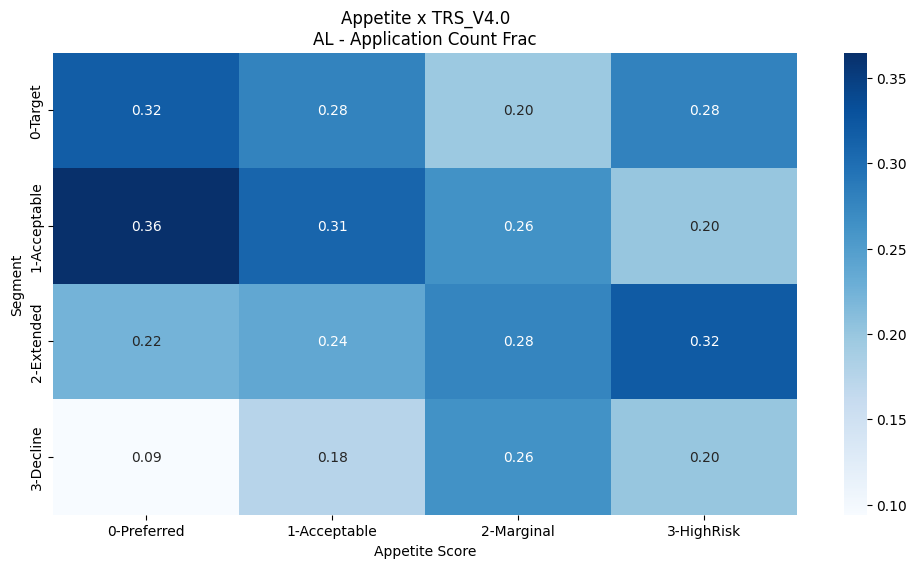

In [18]:
plot_heatmap_app_count(summary, granularity, x_axis, title=f'Appetite x {score_type}_V{score_version}\n{coverage_type} - Application Count Frac')

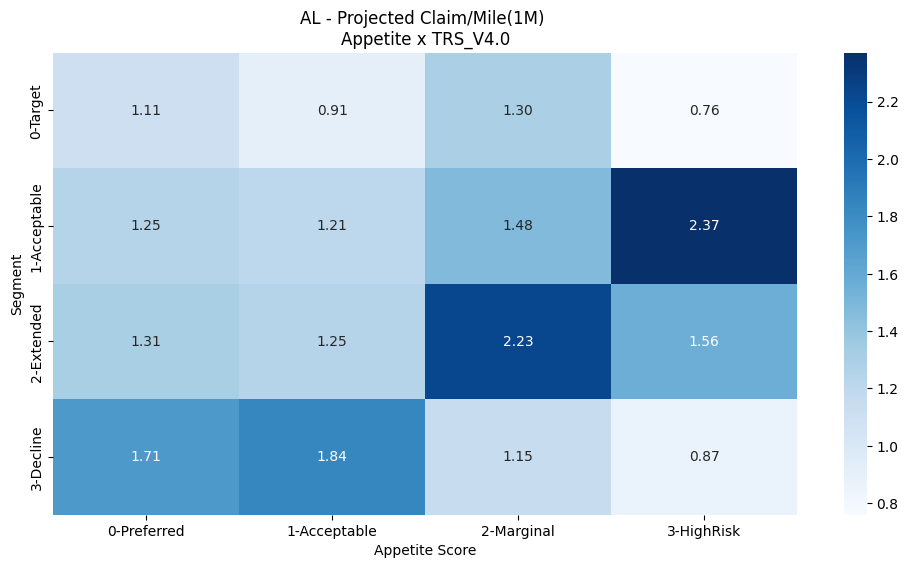

In [19]:
plot_heatmap_claim_frequency(summary, granularity, x_axis, title=f'{coverage_type} - Projected Claim/Mile(1M) \nAppetite x {score_type}_V{score_version}')

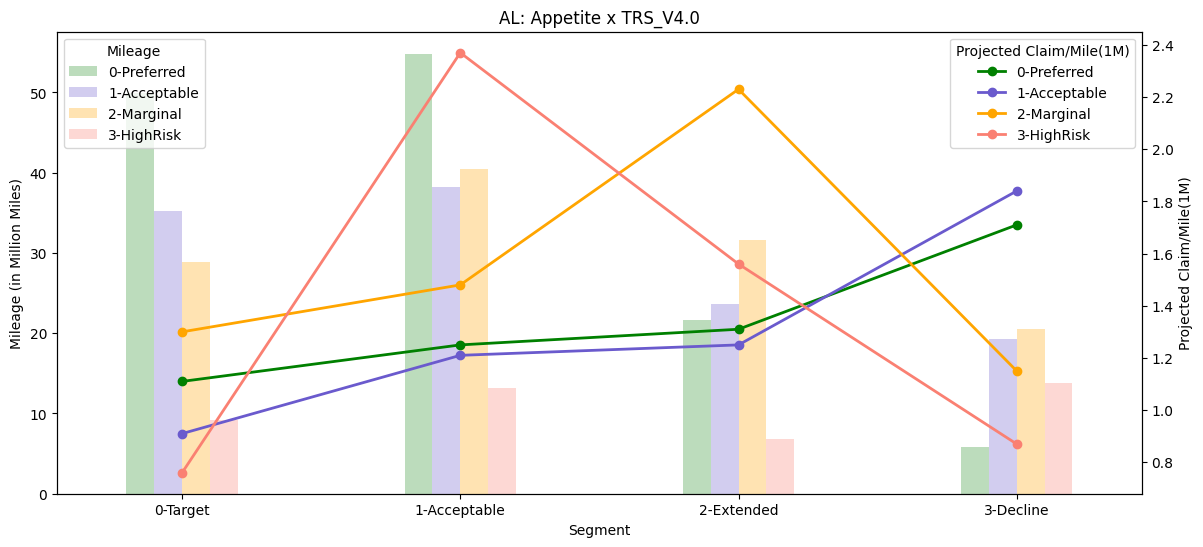

In [20]:
plot_multi_level_claim_frequency(summary, granularity, x_axis, title=f"{coverage_type}: Appetite x {score_type}_V{score_version}", figsize=(14, 6))

### By Renewal

#### Renewal

Generating summary stats for AL
Reading claims data for AL
(116, 18)
Length of evaluation data after merging valid app trs data: 714
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 714


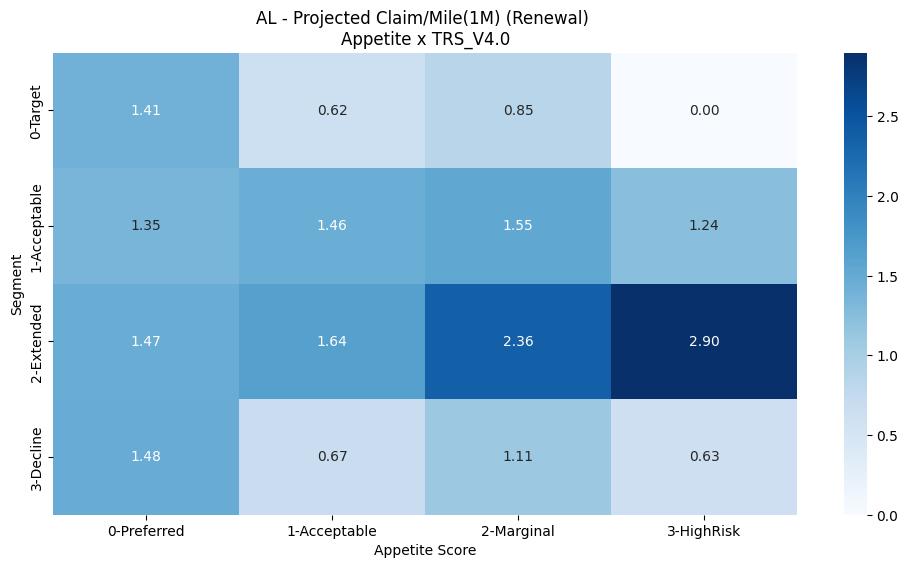

In [21]:
score_type = "TRS"
score_version = 4.0

coverage_type = 'AL'

# coverage_type = 'APD'
x_axis = 'Segment'
granularity = 'Appetite Score'

cut_off_date = pd.to_datetime("2024-10-01")

req_trs_data = bound_app_trs_data[bound_app_trs_data['Is Renewal']== 1]

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    x_axis=x_axis,
    granularity=granularity,
)

plot_heatmap_claim_frequency(summary, granularity, x_axis, title=f'{coverage_type} - Projected Claim/Mile(1M) (Renewal) \nAppetite x {score_type}_V{score_version}')

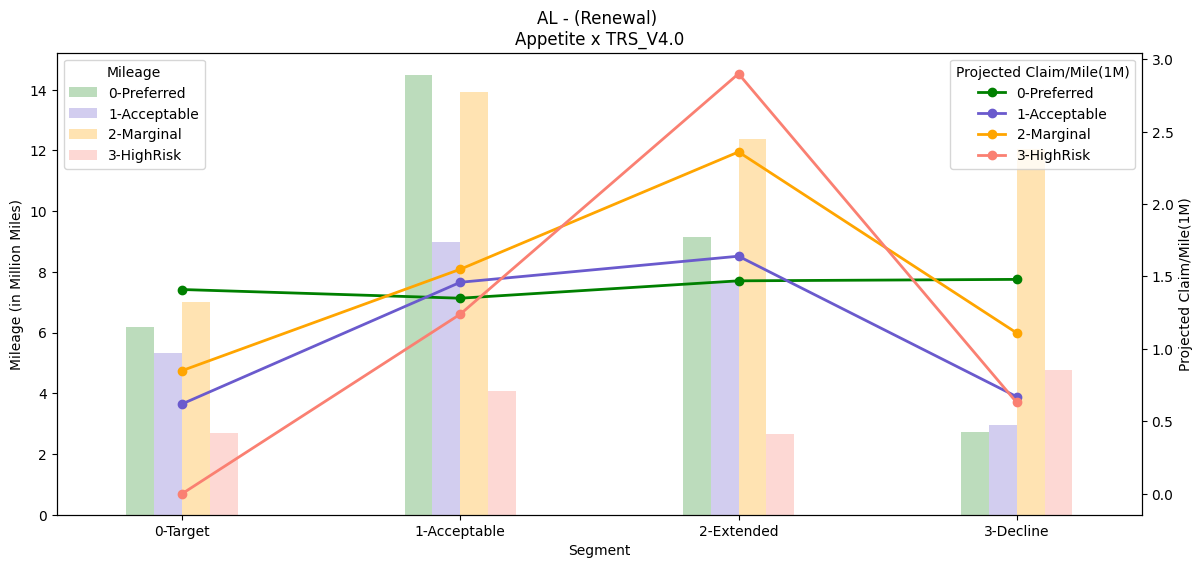

In [22]:
plot_multi_level_claim_frequency(summary, granularity, x_axis, title=f"{coverage_type} - (Renewal) \nAppetite x {score_type}_V{score_version}", figsize=(14, 6))

#### New Business

Generating summary stats for AL
Reading claims data for AL
(205, 18)
Length of evaluation data after merging valid app trs data: 1771
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 1771


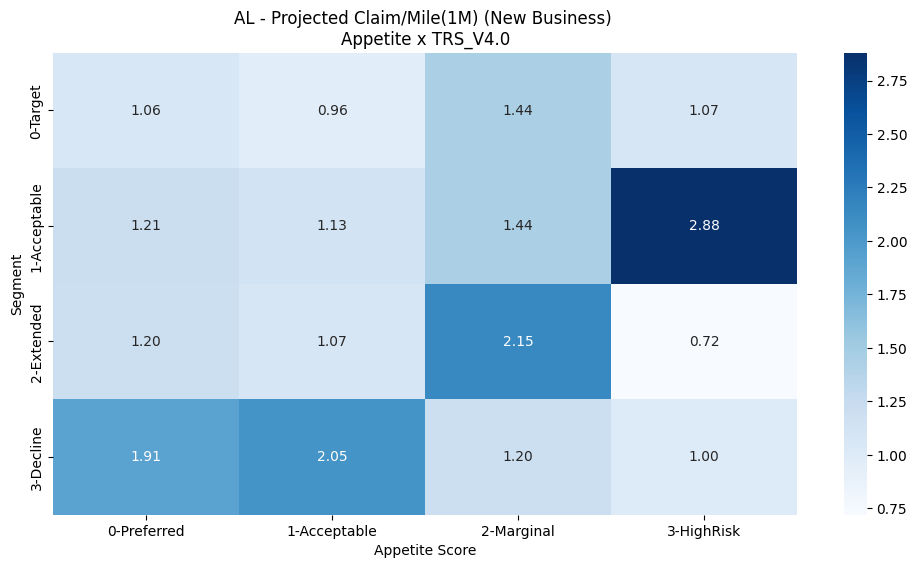

In [23]:
score_type = "TRS"
score_version = 4.0

coverage_type = 'AL'

# coverage_type = 'APD'
x_axis = 'Segment'
granularity = 'Appetite Score'

cut_off_date = pd.to_datetime("2024-10-01")

req_trs_data = bound_app_trs_data[bound_app_trs_data['Is Renewal']== 0]

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    x_axis=x_axis,
    granularity=granularity,
)

plot_heatmap_claim_frequency(summary, granularity, x_axis, title=f'{coverage_type} - Projected Claim/Mile(1M) (New Business) \nAppetite x {score_type}_V{score_version}')

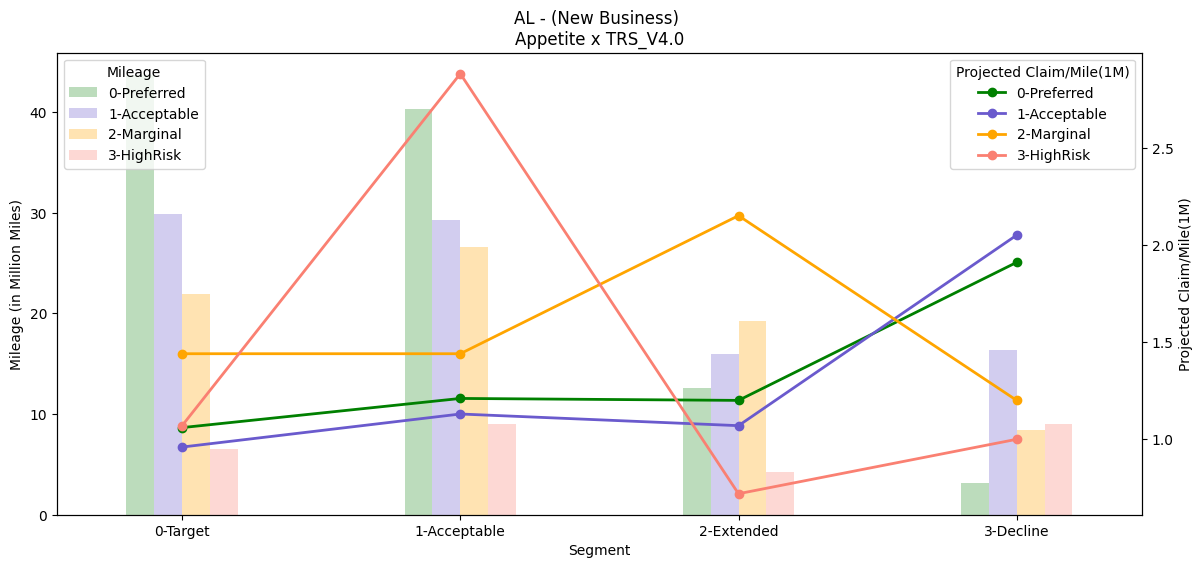

In [24]:
plot_multi_level_claim_frequency(summary, granularity, x_axis, title=f"{coverage_type} - (New Business) \nAppetite x {score_type}_V{score_version}", figsize=(14, 6))

### By Effective Year

#### 2023

Generating summary stats for AL
Reading claims data for AL
(133, 18)
Length of evaluation data after merging valid app trs data: 1618
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 1618


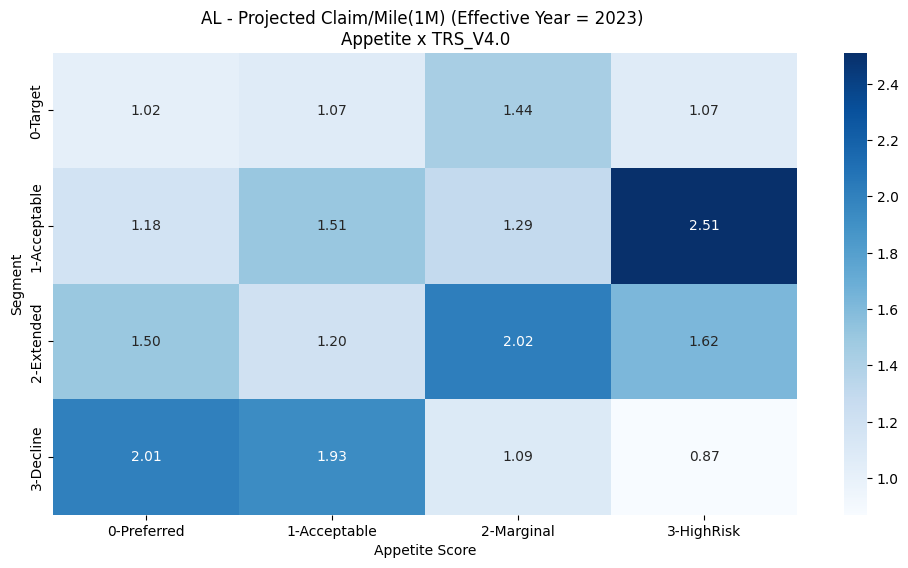

In [25]:
score_type = "TRS"
score_version = 4.0

coverage_type = 'AL'

# coverage_type = 'APD'
x_axis = 'Segment'
granularity = 'Appetite Score'

cut_off_date = pd.to_datetime("2024-10-01")

req_trs_data = bound_app_trs_data[bound_app_trs_data['Effective Date'].dt.year== 2023]

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    x_axis=x_axis,
    granularity=granularity,
)

plot_heatmap_claim_frequency(summary, granularity, x_axis, title=f'{coverage_type} - Projected Claim/Mile(1M) (Effective Year = 2023) \nAppetite x {score_type}_V{score_version}')

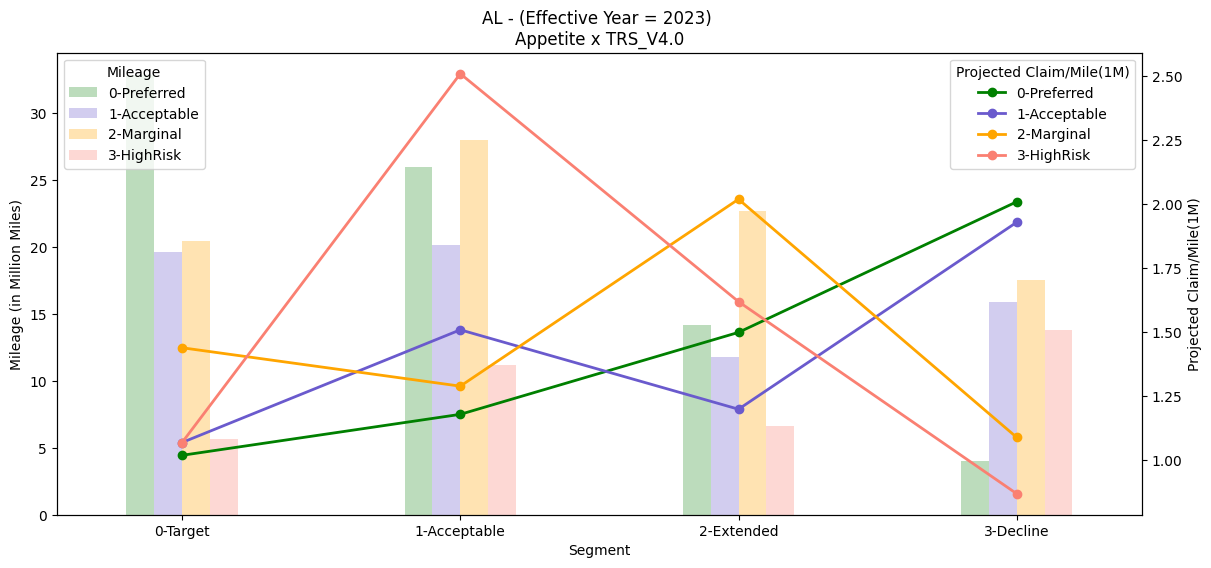

In [26]:
plot_multi_level_claim_frequency(summary, granularity, x_axis, title=f"{coverage_type} - (Effective Year = 2023) \nAppetite x {score_type}_V{score_version}", figsize=(14, 6))

#### 2024

Generating summary stats for AL
Reading claims data for AL
(176, 18)
Length of evaluation data after merging valid app trs data: 717
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 717


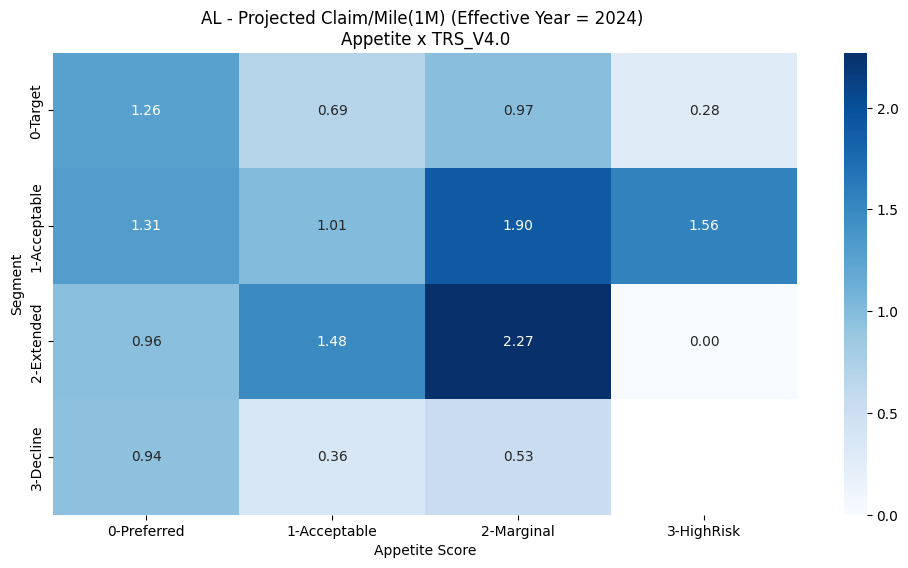

In [27]:
score_type = "TRS"
score_version = 4.0

coverage_type = 'AL'

# coverage_type = 'APD'
x_axis = 'Segment'
granularity = 'Appetite Score'

cut_off_date = pd.to_datetime("2024-10-01")

req_trs_data = bound_app_trs_data[bound_app_trs_data['Effective Date'].dt.year== 2024]

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    x_axis=x_axis,
    granularity=granularity,
)

plot_heatmap_claim_frequency(summary, granularity, x_axis, title=f'{coverage_type} - Projected Claim/Mile(1M) (Effective Year = 2024) \nAppetite x {score_type}_V{score_version}')

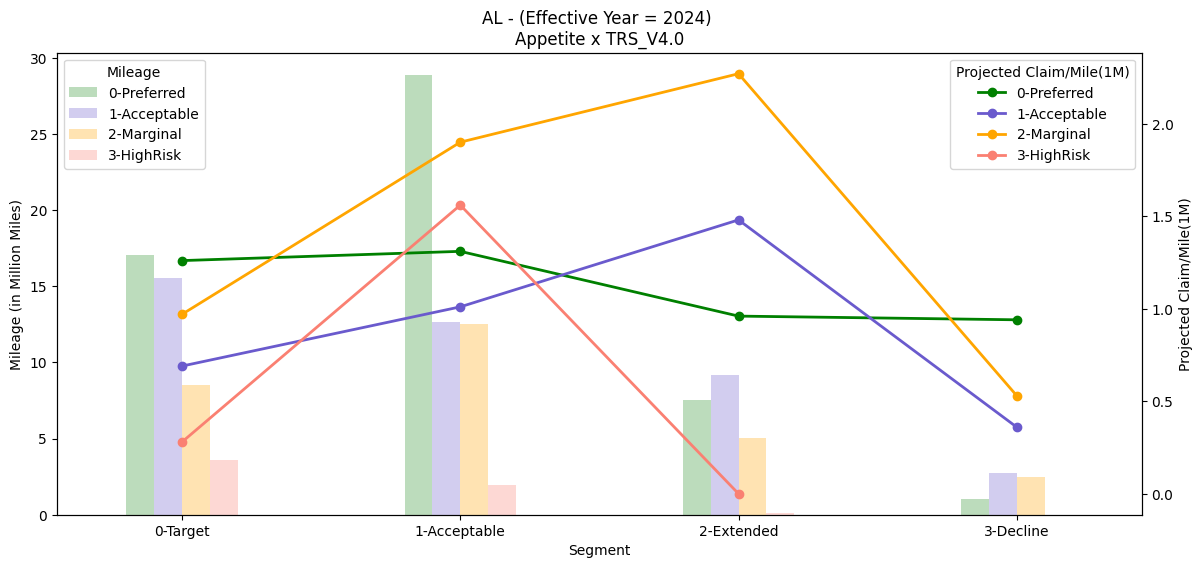

In [28]:
plot_multi_level_claim_frequency(summary, granularity, x_axis, title=f"{coverage_type} - (Effective Year = 2024) \nAppetite x {score_type}_V{score_version}", figsize=(14, 6))

## Recommended Action

### TRS V4

Generating summary stats for AL
Reading claims data for AL
(321, 18)
Length of evaluation data after merging valid app trs data: 2485
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 2485


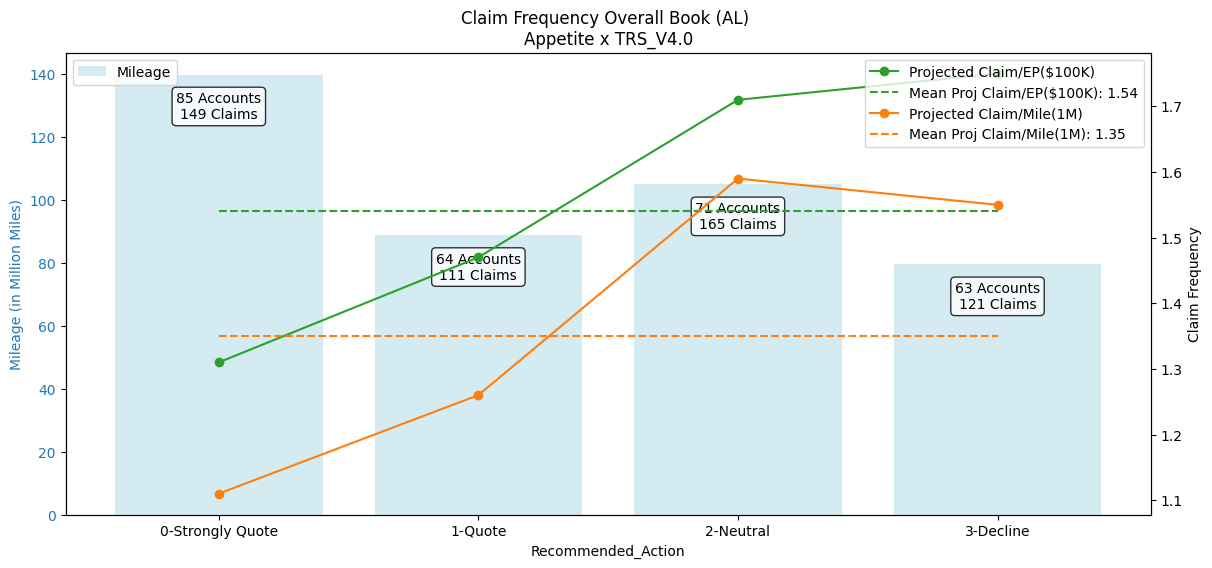

In [30]:
score_type = "TRS"
score_version = 4.0

coverage_type = 'AL'

# coverage_type = 'APD'
x_axis = 'Recommended_Action'

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=bound_app_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    x_axis=x_axis,
)

plot_claim_frequency(summary, x_axis=x_axis, title="Claim Frequency Overall Book ({}) \nAppetite x {}_V{}".format(coverage_type, score_type, score_version), figsize=(14, 6))

#### By effective year

Generating summary stats for AL
Reading claims data for AL
(321, 18)
Length of evaluation data after merging valid app trs data: 2485
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 2485


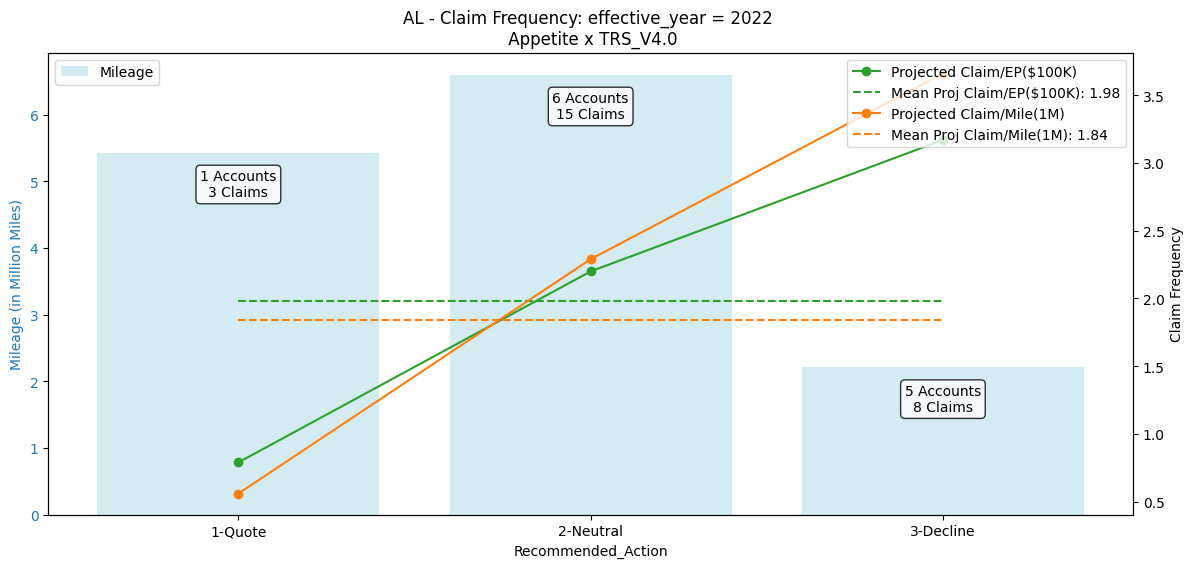

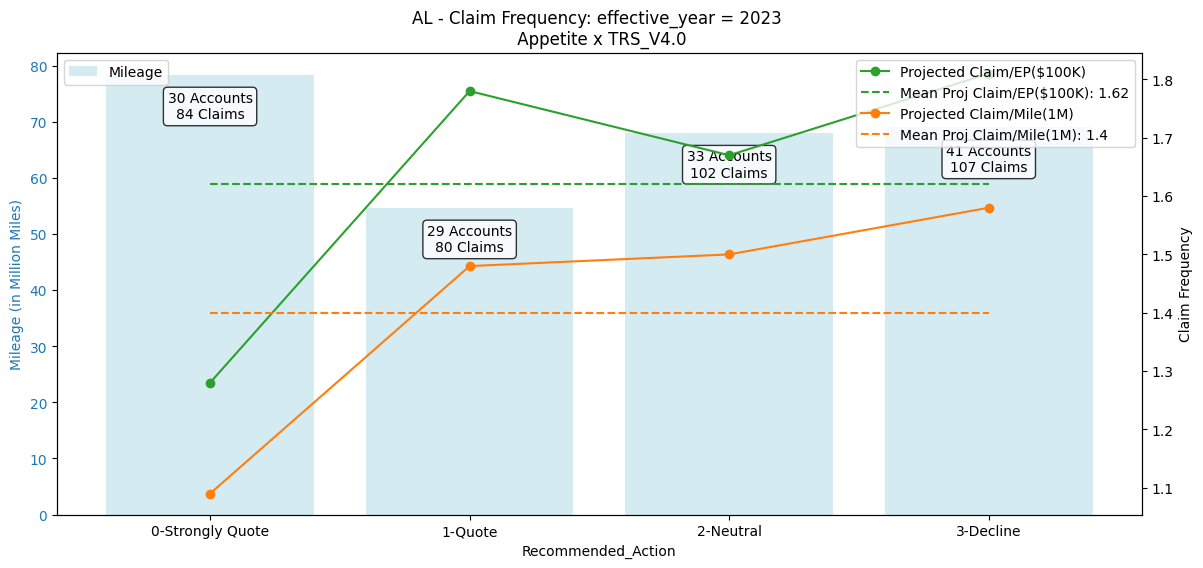

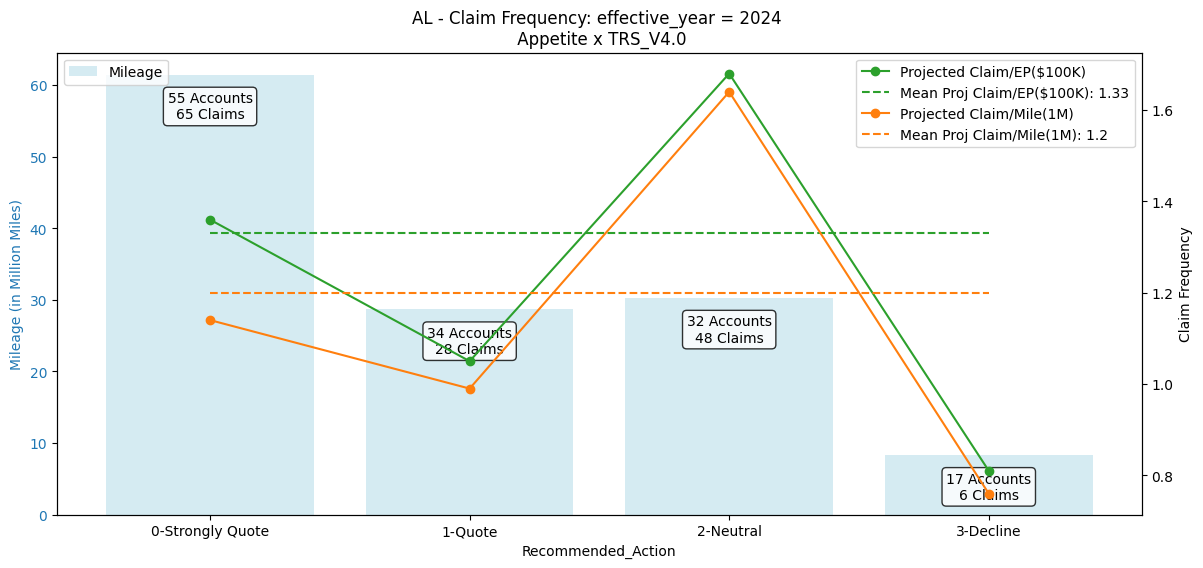

In [31]:
score_type = "TRS"
score_version = 4.0

coverage_type = 'AL'

# coverage_type = 'APD'
x_axis = 'Recommended_Action'
granularity="effective_year"

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=bound_app_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type,
    x_axis=x_axis,
    granularity=granularity
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # print(plot_data)
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            x_axis=x_axis,
            title="{} - Claim Frequency: {} = {} \n Appetite x {}_V{}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6)
        )
        plt.show()

#### By PU count

Generating summary stats for AL
Reading claims data for AL
(321, 18)
Length of evaluation data after merging valid app trs data: 2485
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 2485


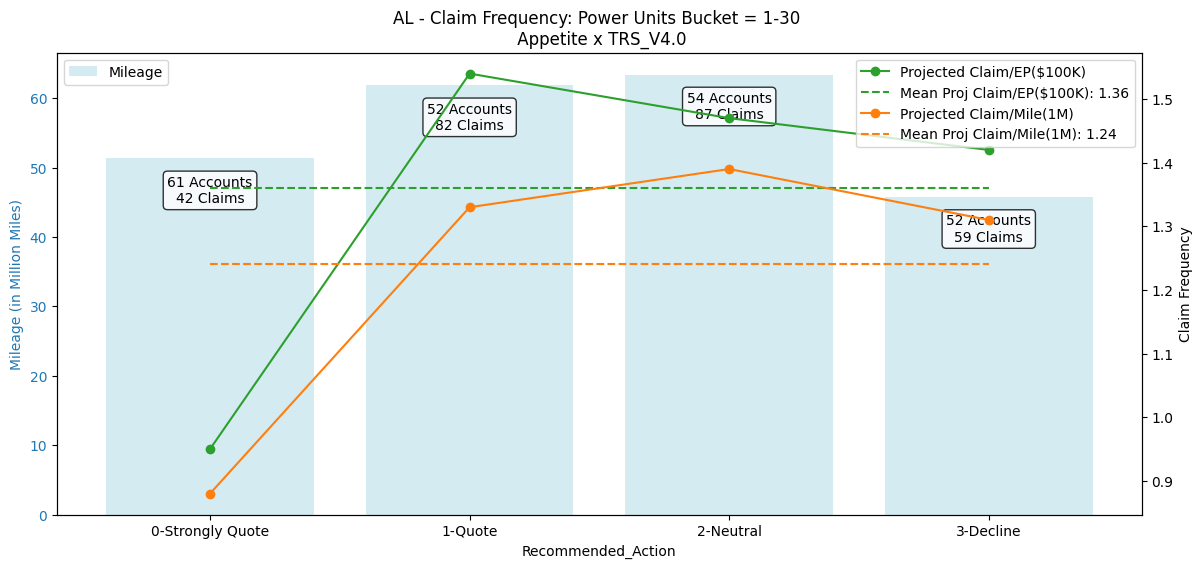

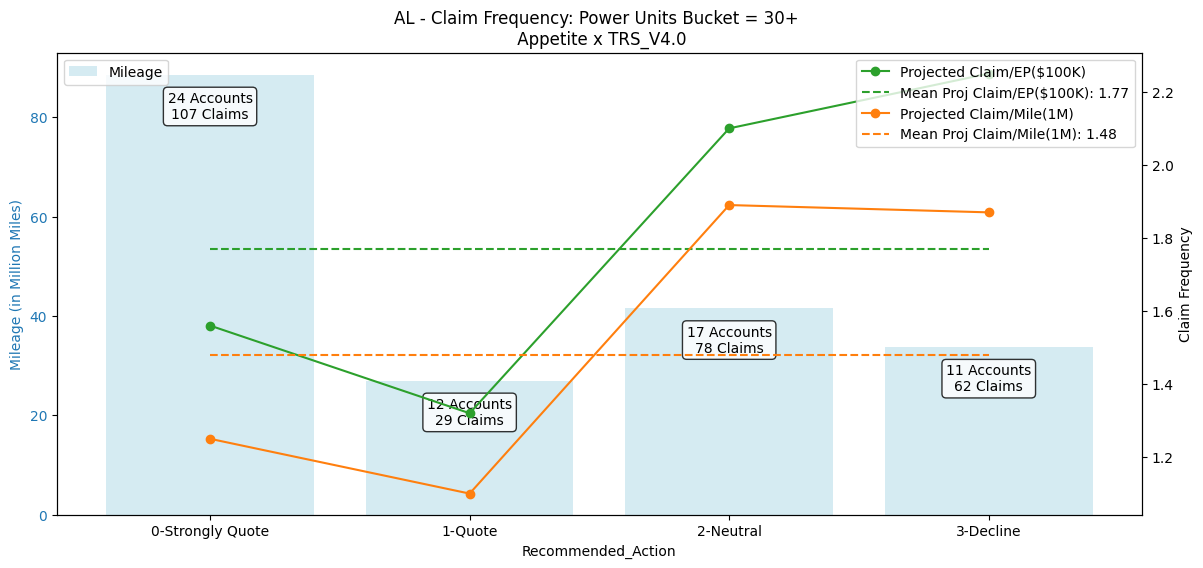

In [32]:
score_type = "TRS"
score_version = 4.0

coverage_type = 'AL'

# coverage_type = 'APD'
x_axis = 'Recommended_Action'
granularity='Power Units Bucket'

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=bound_app_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    x_axis=x_axis,
    granularity=granularity
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # print(plot_data)
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            x_axis=x_axis,
            title="{} - Claim Frequency: {} = {} \n Appetite x {}_V{}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6)
        )
        plt.show()

### GPS 10 Sec

Generating summary stats for AL
Reading claims data for AL
(475, 18)
Length of evaluation data after merging valid app trs data: 3446
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 3446


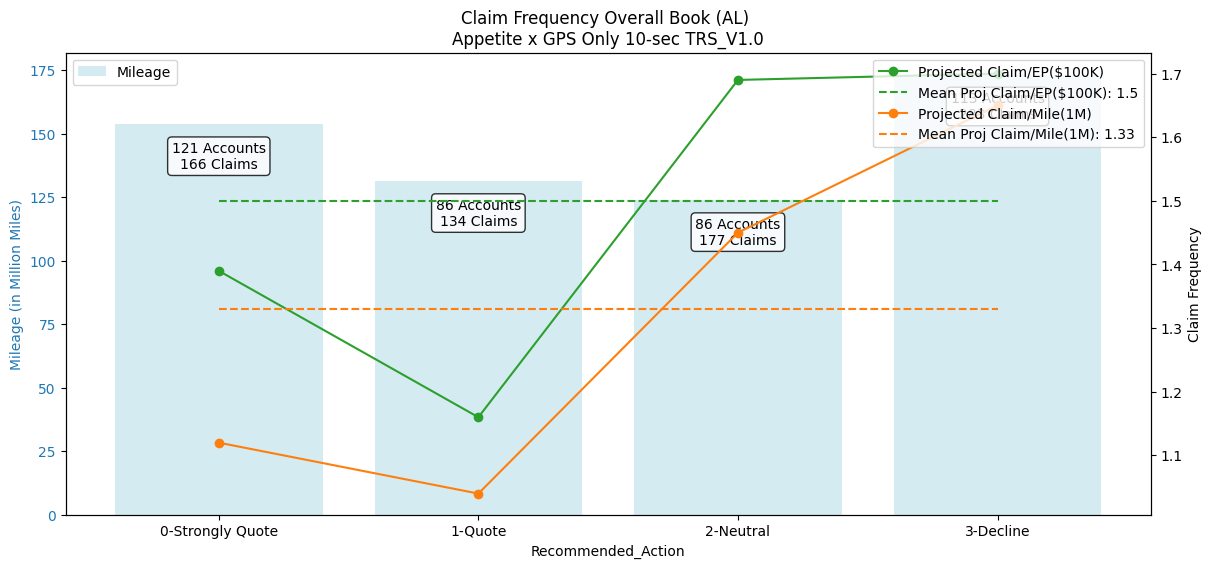

In [33]:
score_type = "GPS Only 10-sec TRS"
score_version = 1.0

coverage_type = 'AL'

# coverage_type = 'APD'
x_axis = 'Recommended_Action'

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=bound_app_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    x_axis=x_axis,
)

plot_claim_frequency(summary, x_axis=x_axis, title="Claim Frequency Overall Book ({}) \nAppetite x {}_V{}".format(coverage_type, score_type, score_version), figsize=(14, 6))

Generating summary stats for AL
Reading claims data for AL
(475, 18)
Length of evaluation data after merging valid app trs data: 3446
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 3446


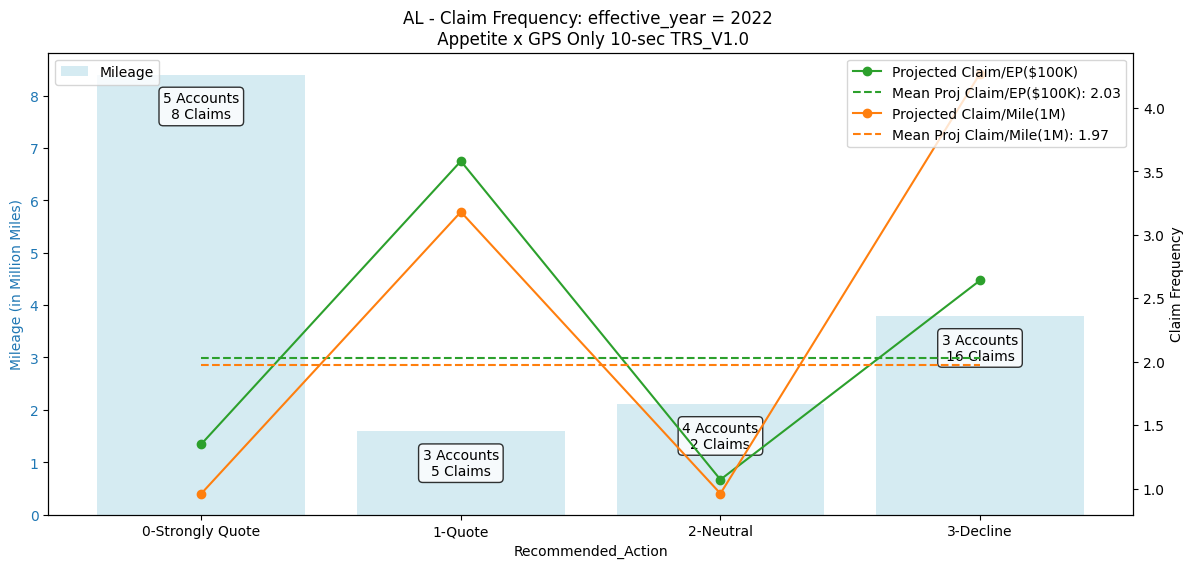

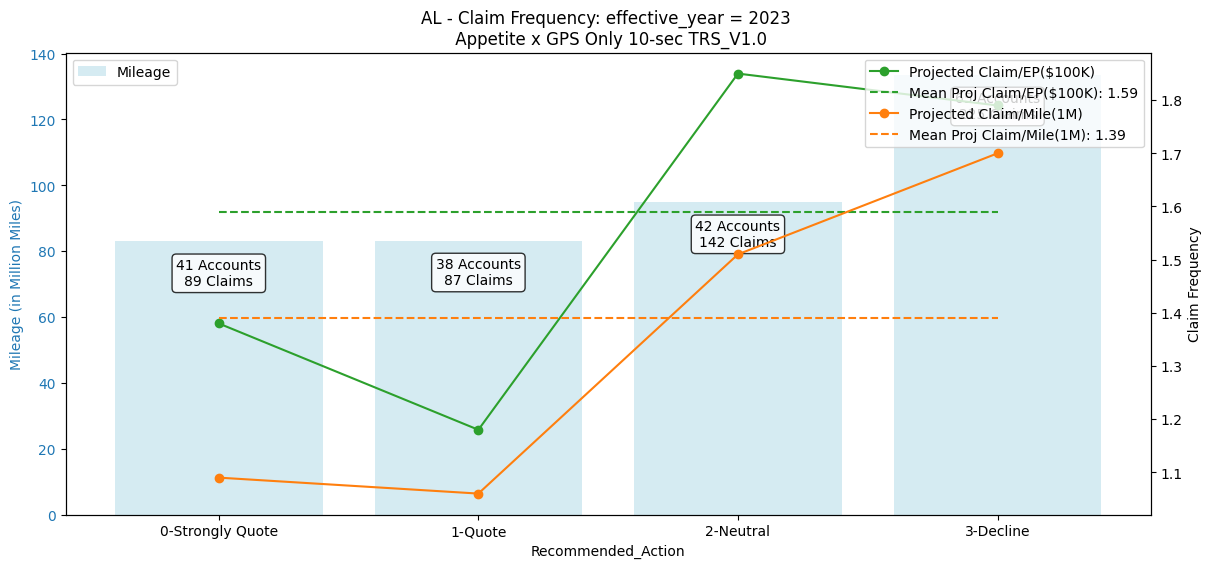

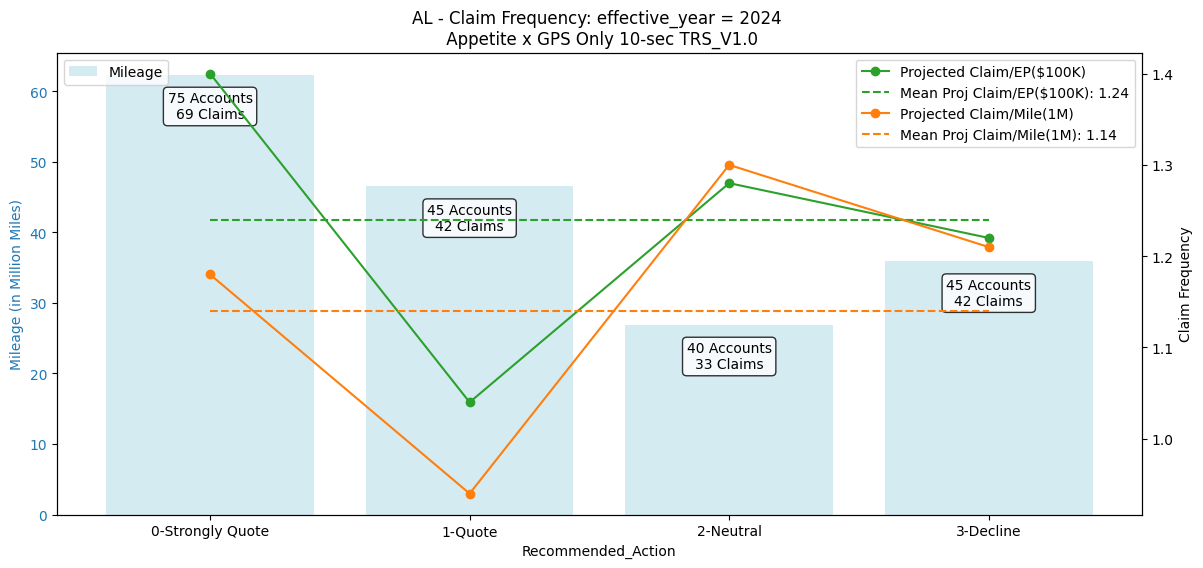

In [34]:
score_type = "GPS Only 10-sec TRS"
score_version = 1.0

coverage_type = 'AL'

# coverage_type = 'APD'
x_axis = 'Recommended_Action'
granularity="effective_year"

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=bound_app_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    x_axis=x_axis,
    granularity=granularity
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # print(plot_data)
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            x_axis=x_axis,
            title="{} - Claim Frequency: {} = {} \n Appetite x {}_V{}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6)
        )
        plt.show()

#### By PU Count

Generating summary stats for AL
Reading claims data for AL
(475, 18)
Length of evaluation data after merging valid app trs data: 3446
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 3446


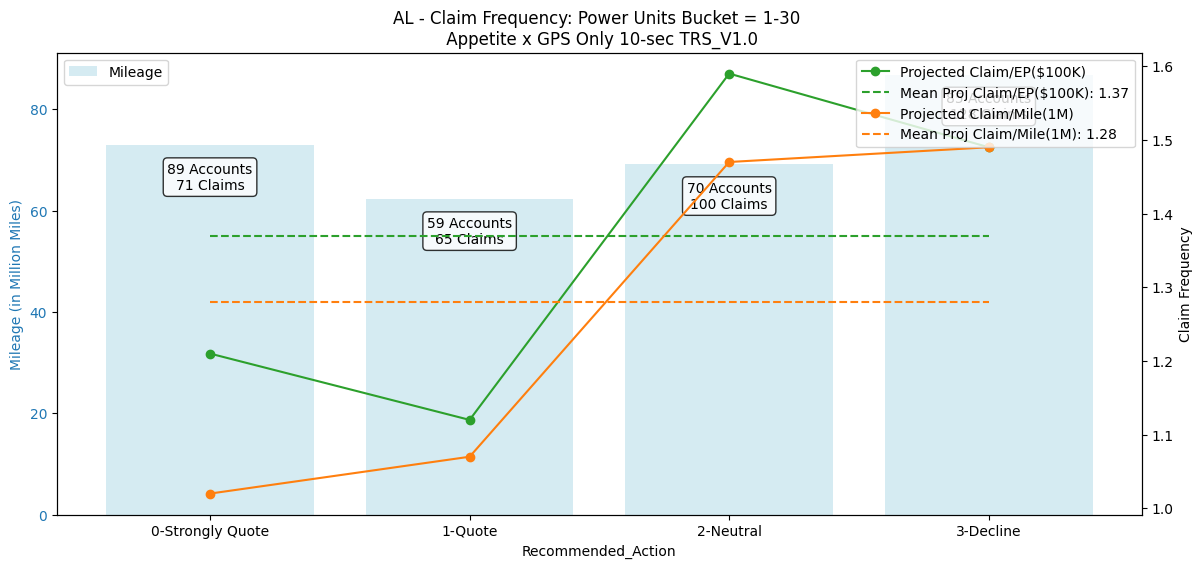

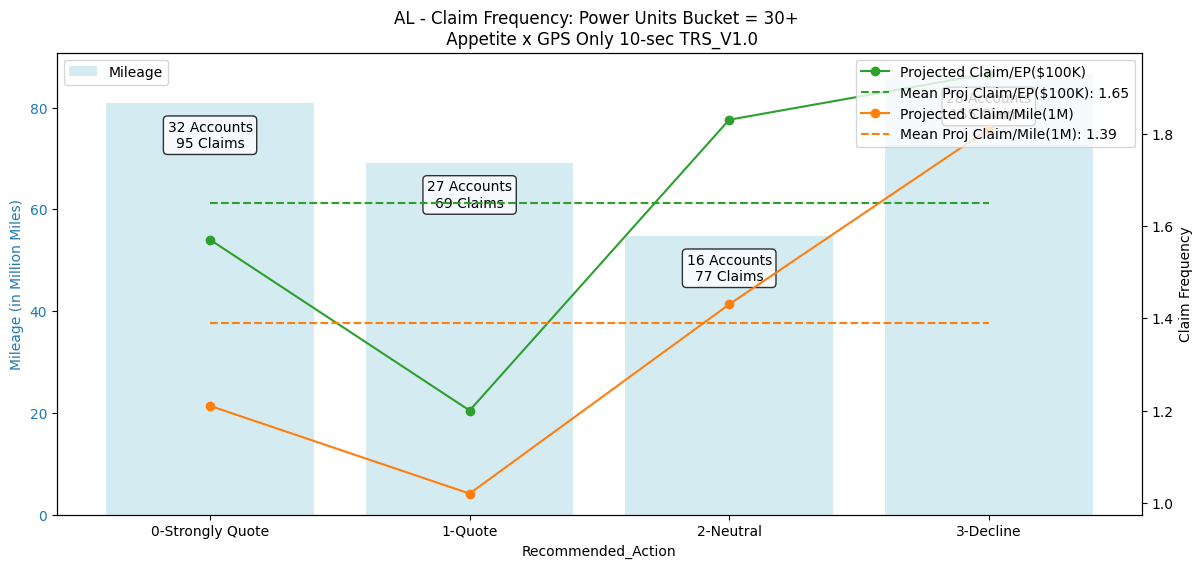

In [35]:
score_type = "GPS Only 10-sec TRS"
score_version = 1.0

coverage_type = 'AL'

# coverage_type = 'APD'
x_axis = 'Recommended_Action'
granularity='Power Units Bucket'

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=bound_app_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type,
    x_axis=x_axis,
    granularity=granularity
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # print(plot_data)
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            x_axis=x_axis,
            title="{} - Claim Frequency: {} = {} \n Appetite x {}_V{}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6)
        )
        plt.show()

## Overall Book

In [22]:
trs_launch_date = datetime(2023, 12, 1)

trs_data = bound_app_trs_data.copy(deep=True)
trs_data['Effective Dates'] = pd.to_datetime(trs_data['Effective Date'], errors='coerce')
pre_trs_data = trs_data[trs_data['Effective Dates']<trs_launch_date]
post_trs_data = trs_data[trs_data['Effective Dates']>=trs_launch_date]

In [23]:
req_trs_data = bound_app_trs_data.copy(deep=True)

In [24]:
eval_date = "December 1 2024"

cut_off_date = pd.to_datetime("2024-12-01")

claim_count_col = 'Claim Count'
projected_claim_col = 'Projected Claims'
granularity='Is Renewal'

### AL

Generating summary stats for AL
Reading claims data for AL
(321, 18)
Length of evaluation data after merging valid app trs data: 2680
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 2680


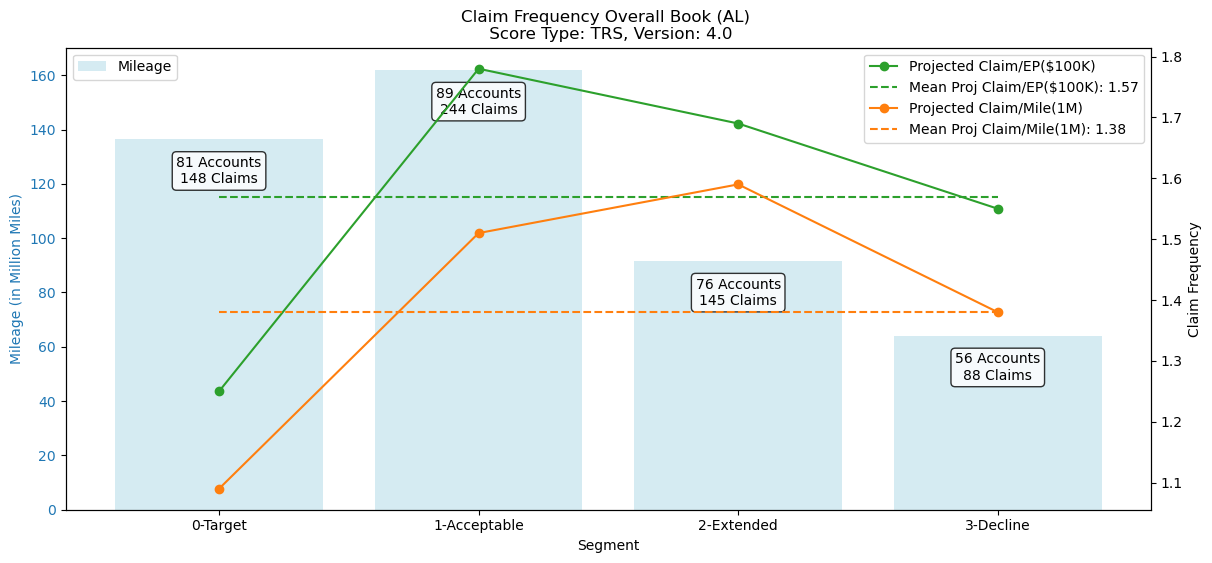

In [25]:
score_type = "TRS"
score_version = 4.0

coverage_type = 'AL'

# coverage_type = 'APD'
x_axis = 'Segment'

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    x_axis=x_axis,
)

plot_claim_frequency(summary, x_axis=x_axis, title="Claim Frequency Overall Book ({}) \n Score Type: {}, Version: {}".format(coverage_type, score_type, score_version), figsize=(14, 6))

In [194]:
analysis_data.columns

Index(['Application ID', 'Connection ID', 'Effective Date', 'Tsp Enum',
       'Is Quoted', 'Is Renewal', 'Is Bound', 'Score Type', 'Version',
       'Start Date', 'End Date', 'Vin Count', 'Score', 'Days To Effective',
       'Segment', 'Appetite Score', 'Pre_TRS', 'Recommended_Action',
       'Billed Mileage Id', 'Mileage', 'Billed Month', 'Claim Count',
       'Projected Claims', 'Amount', 'Power Units', 'Power Units Bucket',
       'effective_year', 'effective_month', 'effective_quarter',
       'effective_year_half'],
      dtype='object')

In [40]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
dfx = analysis_data[['Application ID', 'Effective Date', 'Appetite Score', 'Score']].drop_duplicates()
dfx.groupby('Appetite Score')['Score'].describe(percentiles=quantiles)

count       mean        std  min   10%    25%   50%   75%  \
Appetite Score                                                              
0-Preferred      85.0  54.564706  27.111958  3.0  21.8  32.00  53.0  80.0   
1-Acceptable     97.0  49.680412  27.476712  1.0  13.0  27.00  52.0  74.0   
2-Marginal       76.0  43.118421  28.156215  3.0   8.0  18.75  37.5  66.5   
3-HighRisk       25.0  47.640000  27.883508  6.0  13.4  27.00  38.0  71.0   

                 90%   max  
Appetite Score              
0-Preferred     92.0  99.0  
1-Acceptable    87.4  97.0  
2-Marginal      84.0  97.0  
3-HighRisk      81.6  98.0

<Axes: title={'center': 'Score'}, xlabel='Appetite Score'>

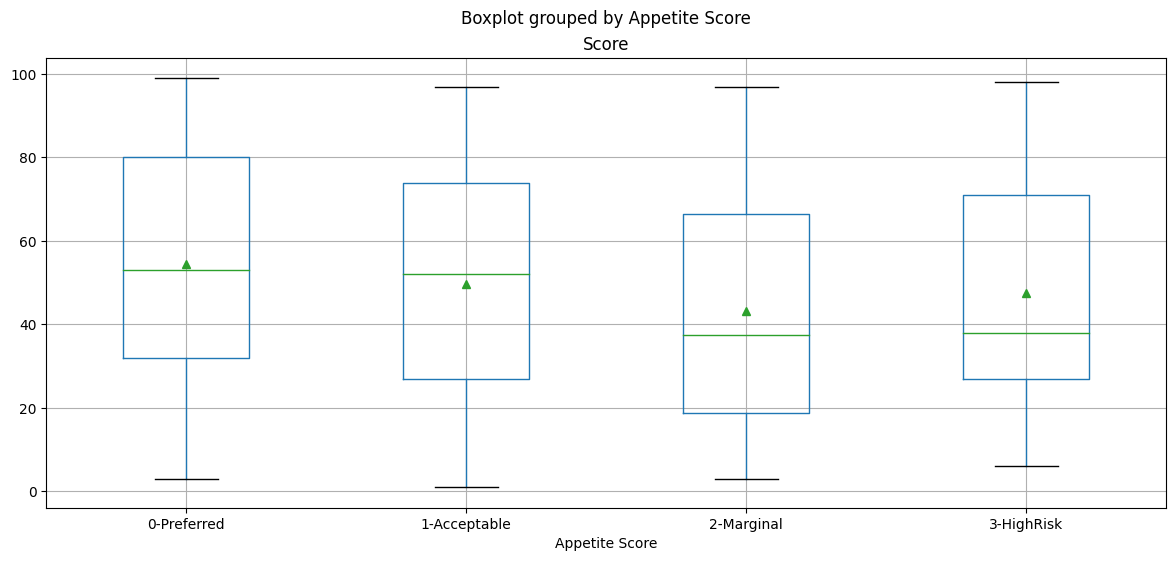

In [41]:
dfx.boxplot(column='Score', by='Appetite Score', figsize=(14, 6), showmeans=True)

### PU Bucket

Generating summary stats for AL
Reading claims data for AL
(321, 18)
Length of evaluation data after merging valid app trs data: 2485
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 2485


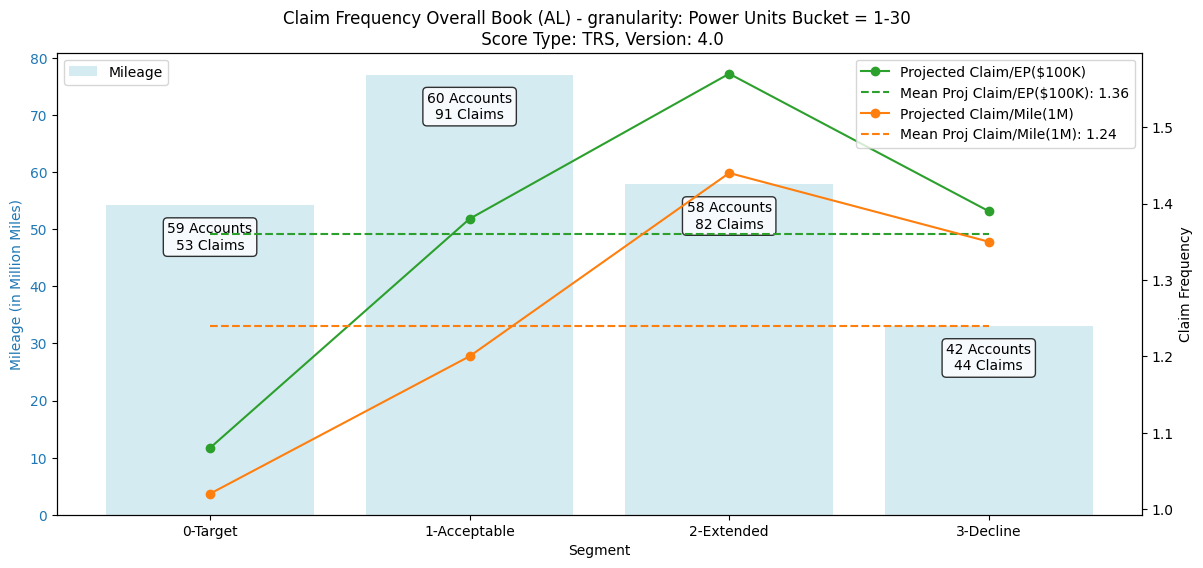

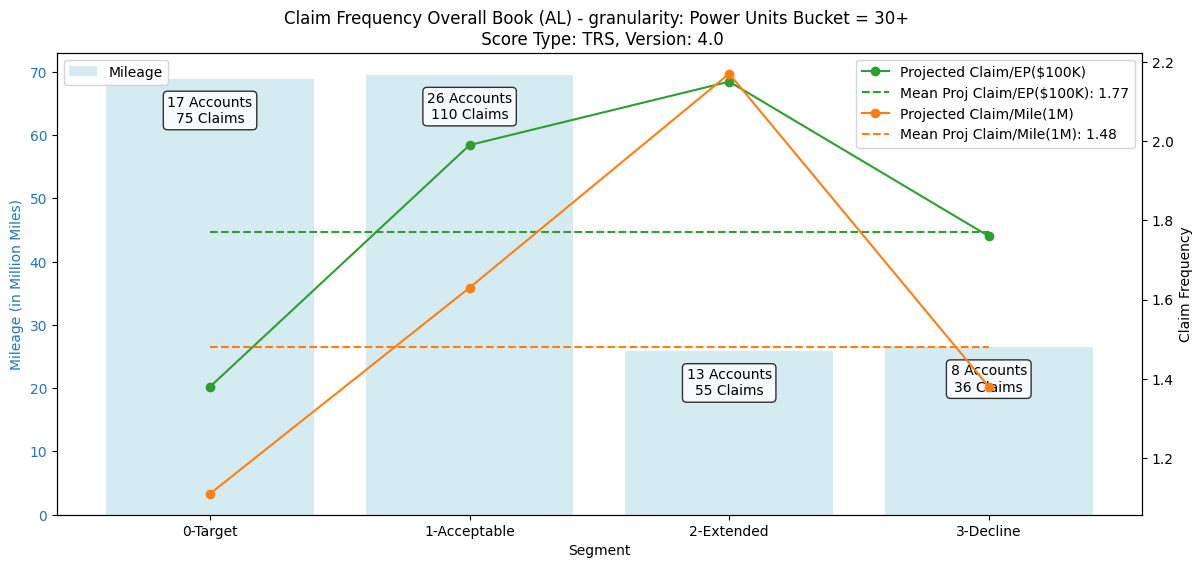

In [42]:
granularity = "Power Units Bucket"

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # print(plot_data)
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Overall Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6)
        )
        plt.show()

#### Pre-Post TRS

Generating summary stats for AL
Reading claims data for AL
(321, 18)
Length of evaluation data after merging valid app trs data: 2485
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 2485


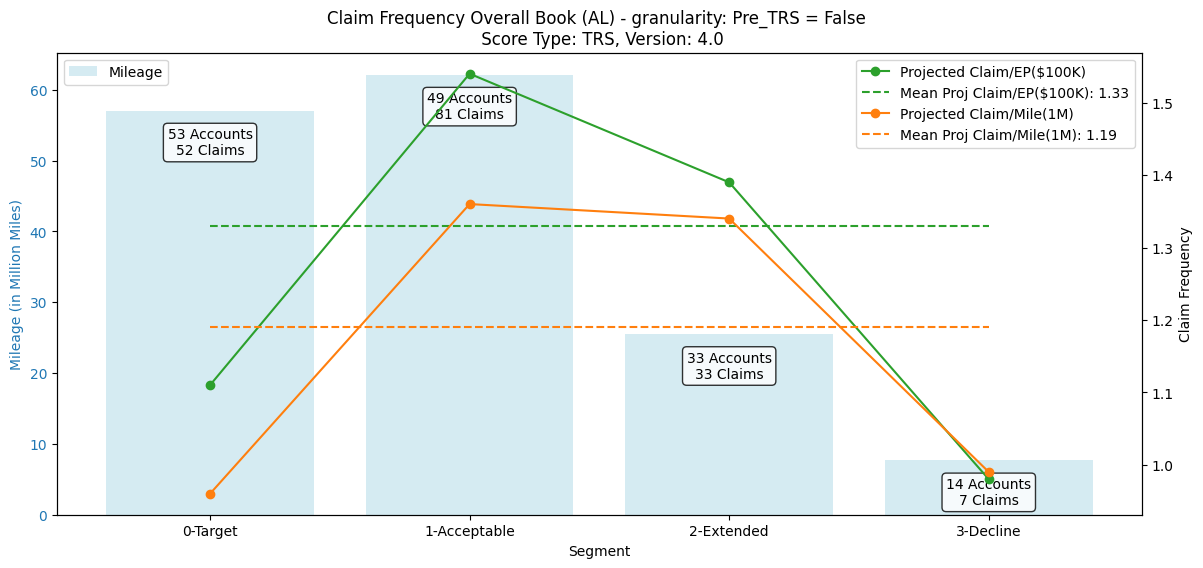

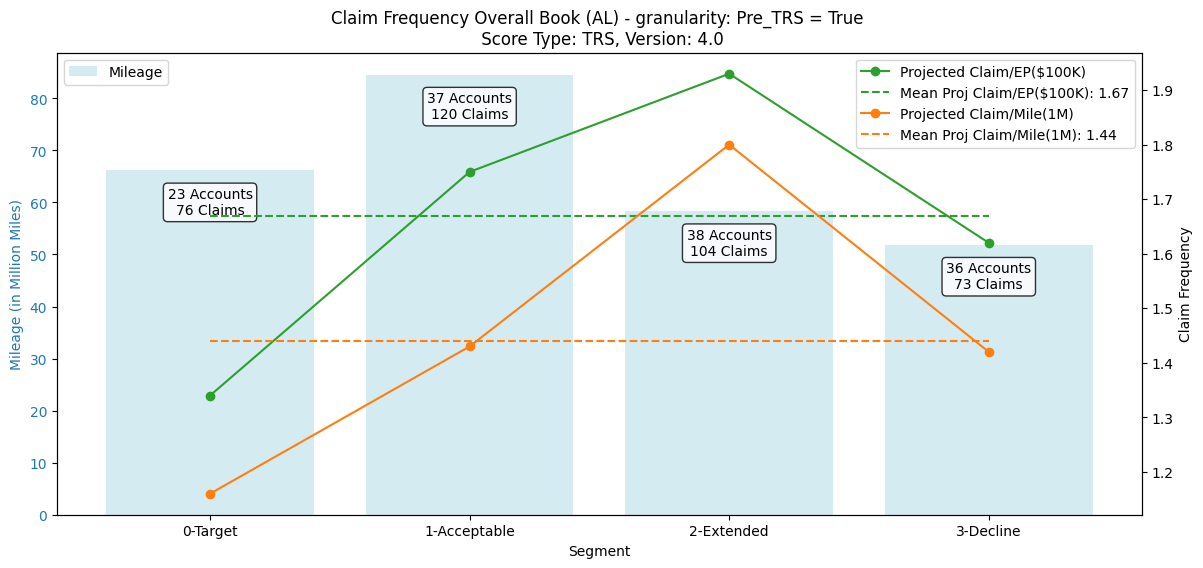

In [43]:
granularity='Pre_TRS'

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # print(plot_data)
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Overall Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6)
        )
        plt.show()

#### By renewal

Generating summary stats for AL
Reading claims data for AL
(321, 18)
Length of evaluation data after merging valid app trs data: 2680
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 2680


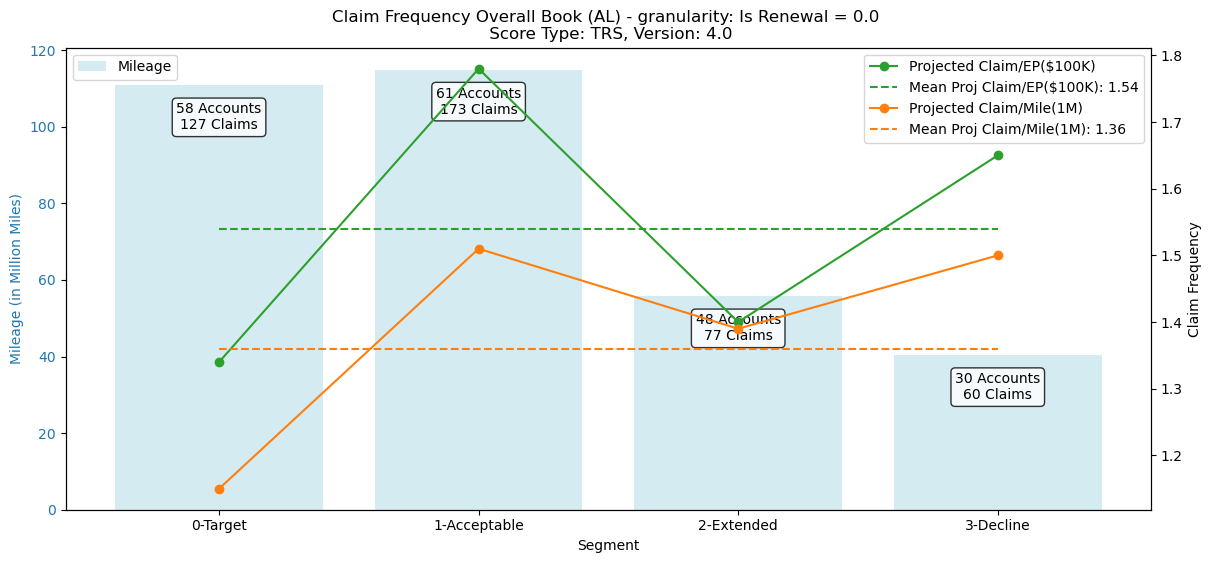

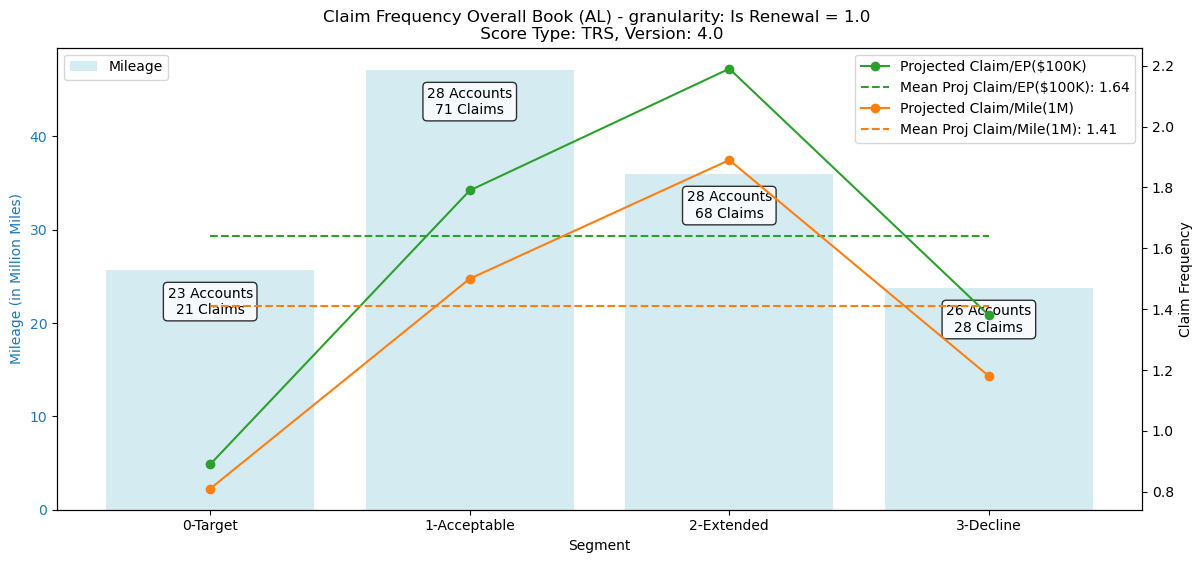

In [26]:
granularity='Is Renewal'

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Overall Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14,6)
        )
        plt.show()

#### By effective year

Generating summary stats for AL
Reading claims data for AL
(321, 18)
Length of evaluation data after merging valid app trs data: 2485
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 2485


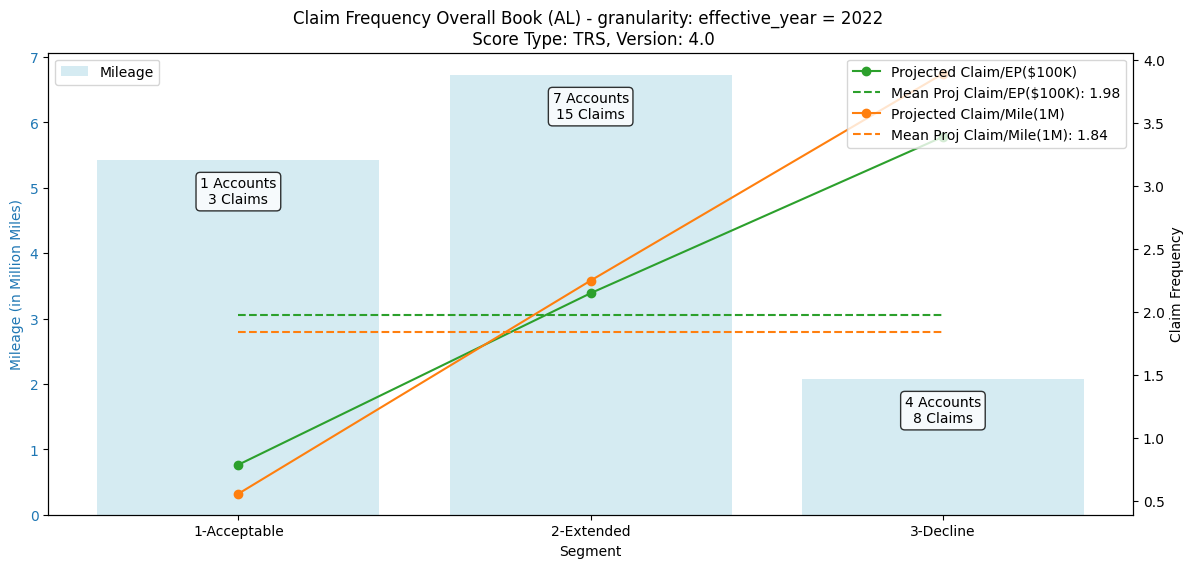

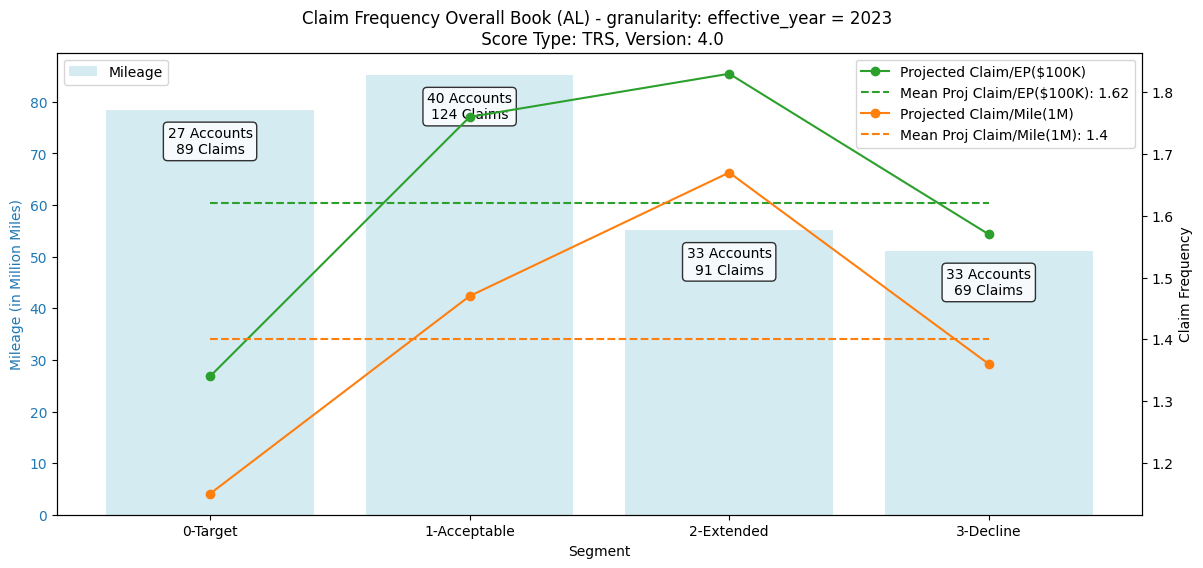

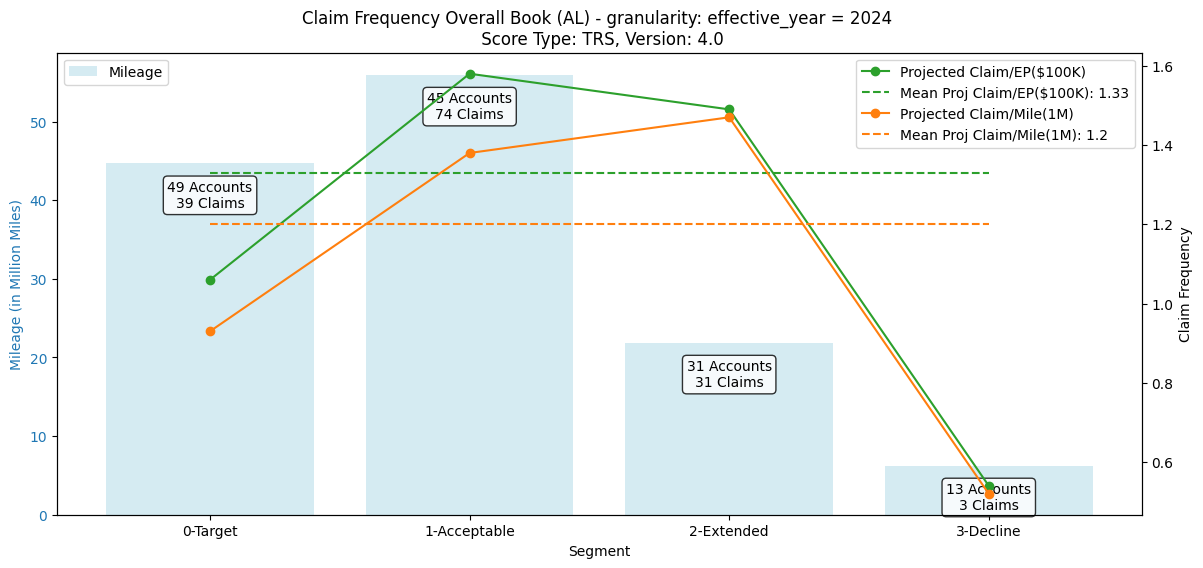

In [45]:
granularity='effective_year'

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Overall Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6)
        )
        plt.show()

#### Pre-TRS by Renewal

Generating summary stats for AL
Reading claims data for AL
(134, 18)
Length of evaluation data after merging valid app trs data: 1661
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 1661


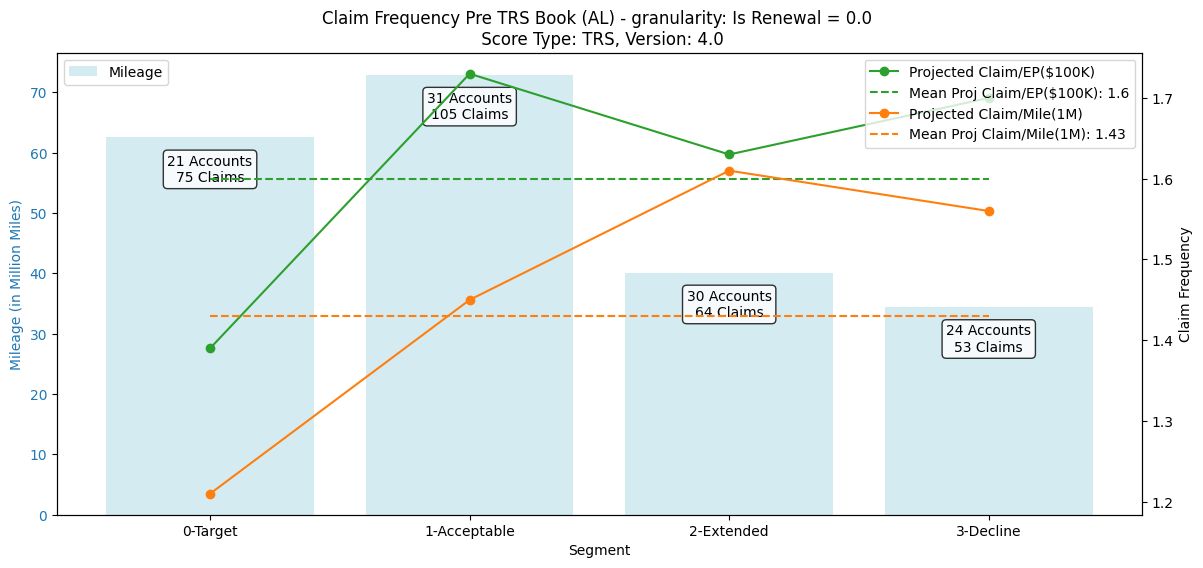

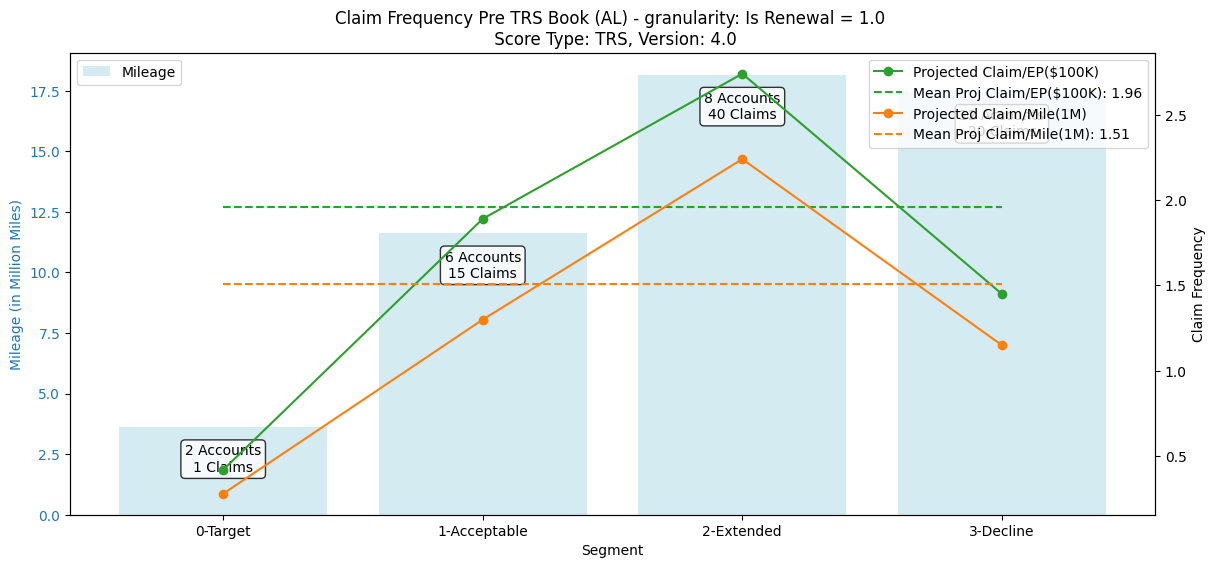

In [46]:
granularity='Is Renewal'

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=pre_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Pre TRS Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14,6)
        )
        plt.show()

Generating summary stats for AL
Reading claims data for AL
(134, 18)
Length of evaluation data after merging valid app trs data: 1661
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 1661


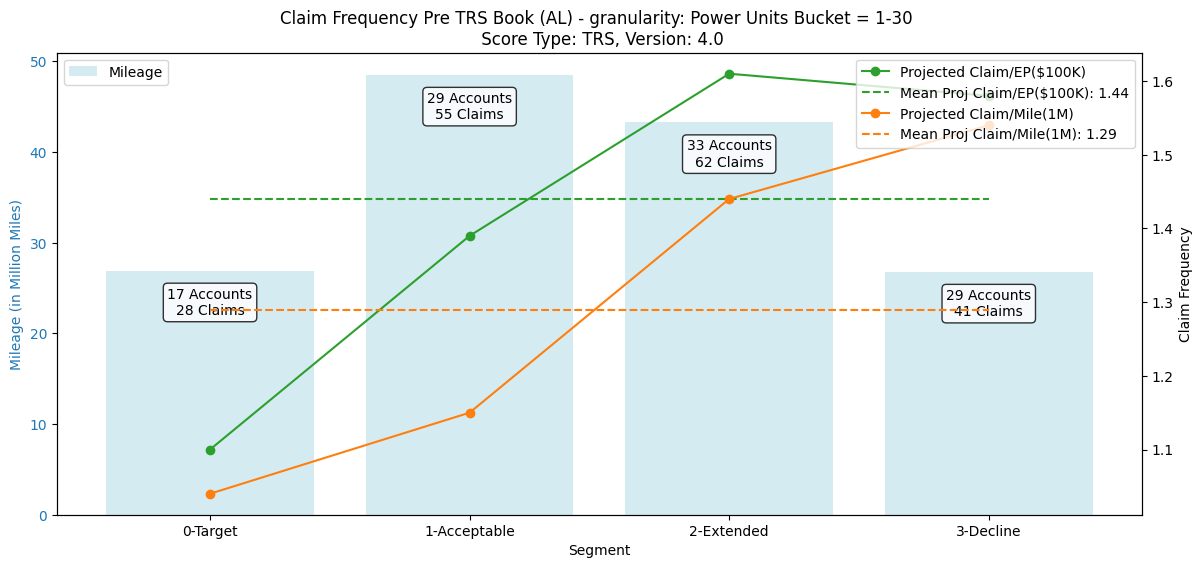

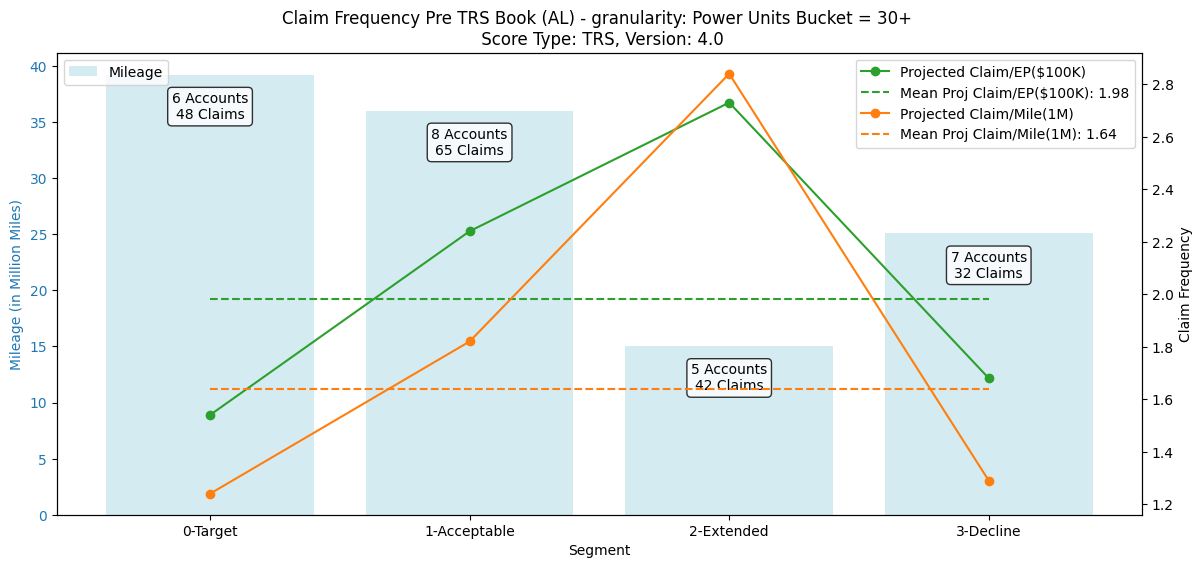

In [47]:
granularity='Power Units Bucket'

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=pre_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Pre TRS Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14,6)
        )
        plt.show()

#### Post-TRS By Renewal

Generating summary stats for AL
Reading claims data for AL
(187, 18)
Length of evaluation data after merging valid app trs data: 824
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 824


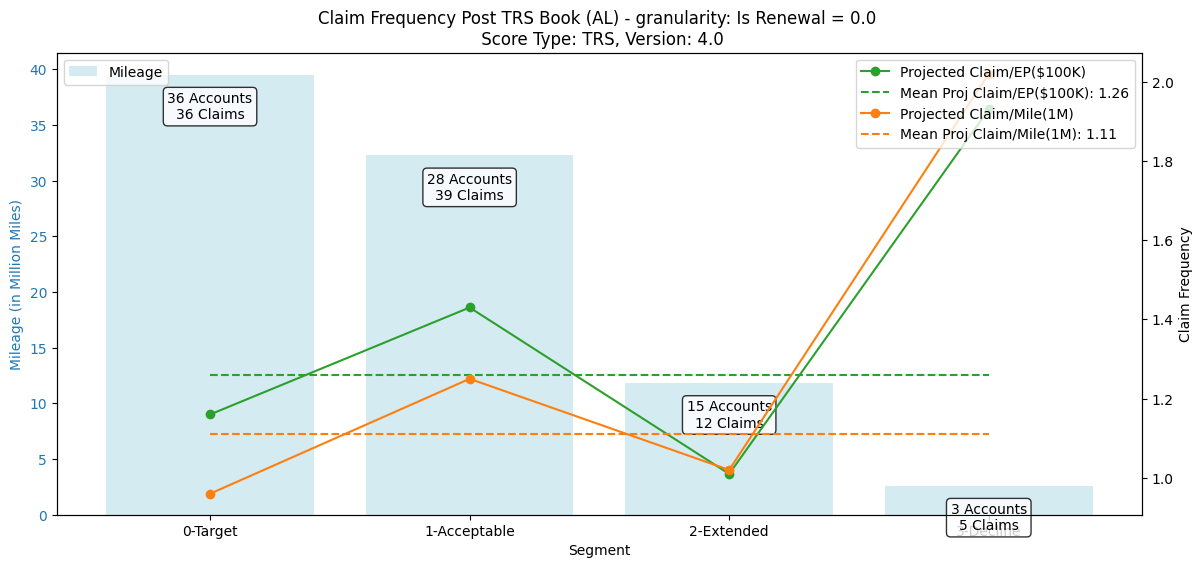

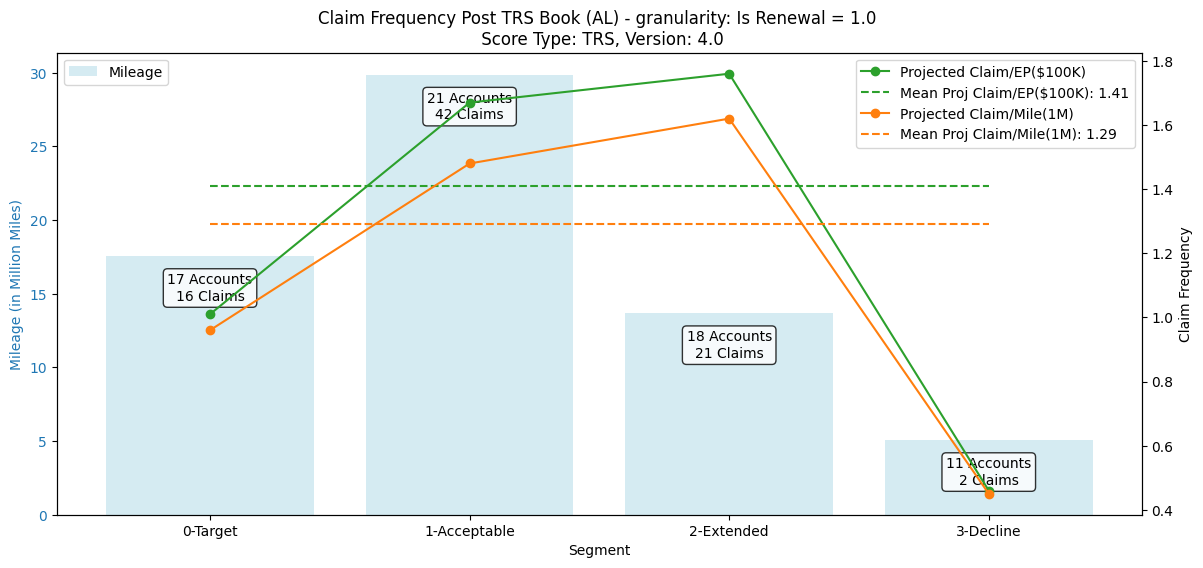

In [48]:
granularity='Is Renewal'

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=post_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Post TRS Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14,6)
        )
        plt.show()

##### Pu Bucket

Generating summary stats for AL
Reading claims data for AL
(187, 18)
Length of evaluation data after merging valid app trs data: 824
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 824


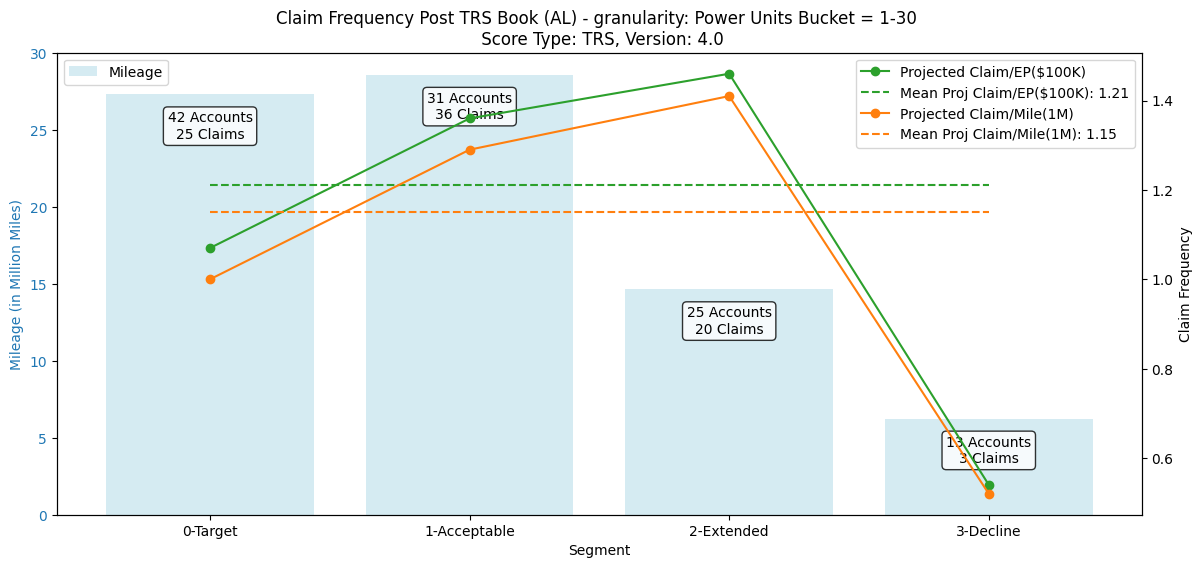

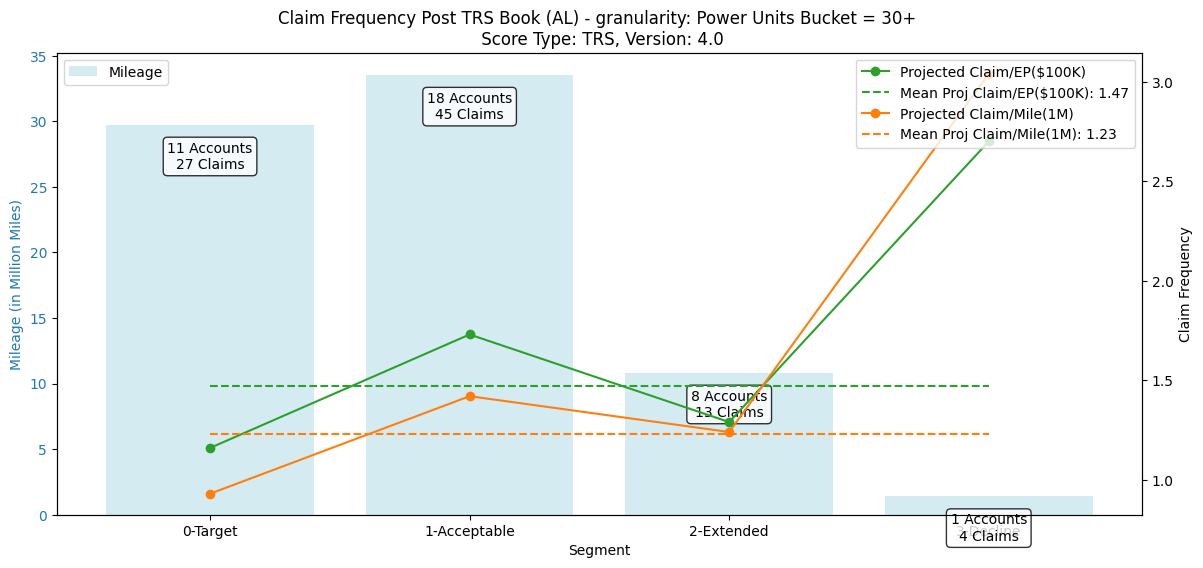

In [49]:
granularity='Power Units Bucket'

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=post_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Post TRS Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14,6)
        )
        plt.show()

### APD

Generating summary stats for APD
Reading claims data for APD
(321, 15)
Length of evaluation data after merging valid app trs data: 2485


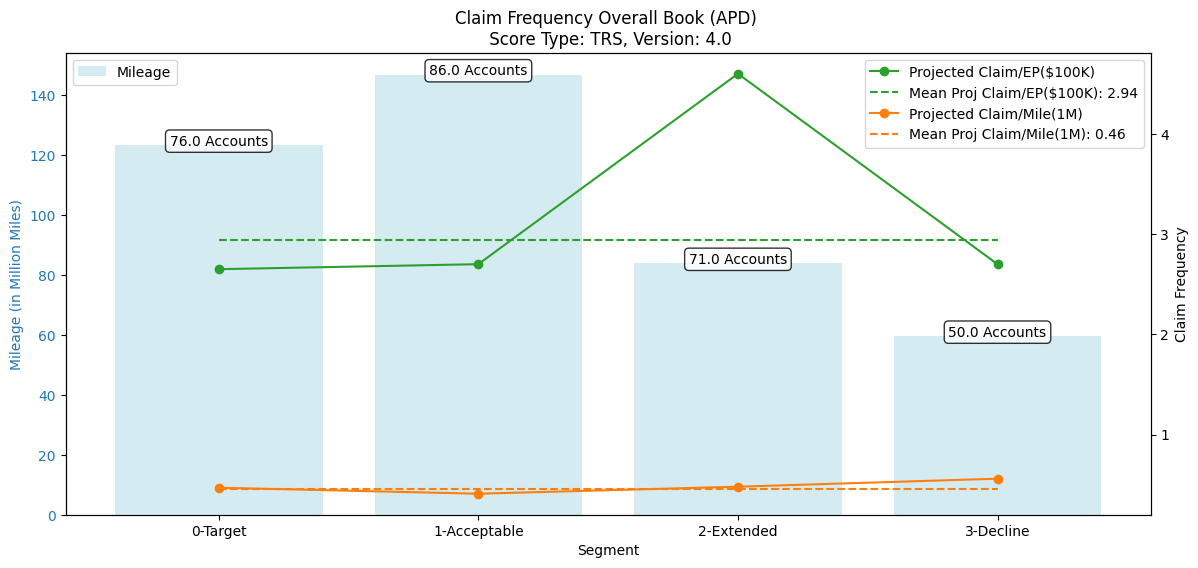

In [317]:
score_type = "TRS"
score_version = 4.0

# coverage_type = 'AL'

coverage_type = 'APD'

analysis_data, summary = generate_summary_stats(
    eval_date=eval_date, 
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    trs_launch_date=trs_launch_date,
)

plot_claim_frequency(summary, title="Claim Frequency Overall Book ({}) \n Score Type: {}, Version: {}".format(coverage_type, score_type, score_version), figsize=(14, 6))

#### Pre-Post TRS

Generating summary stats for APD
Reading claims data for APD
(321, 15)
Length of evaluation data after merging valid app trs data: 2485


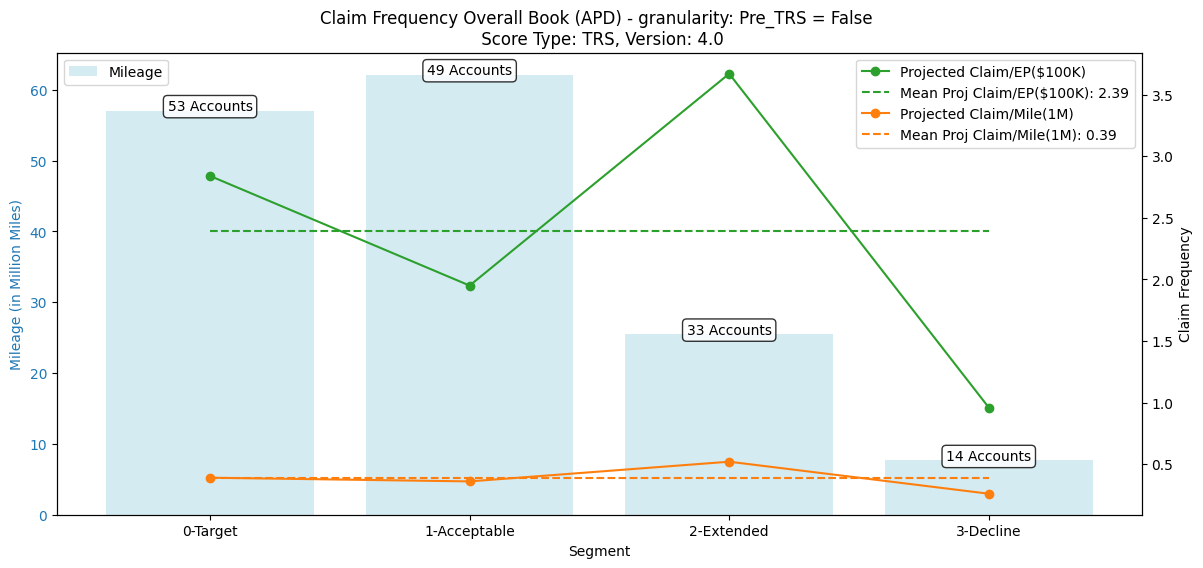

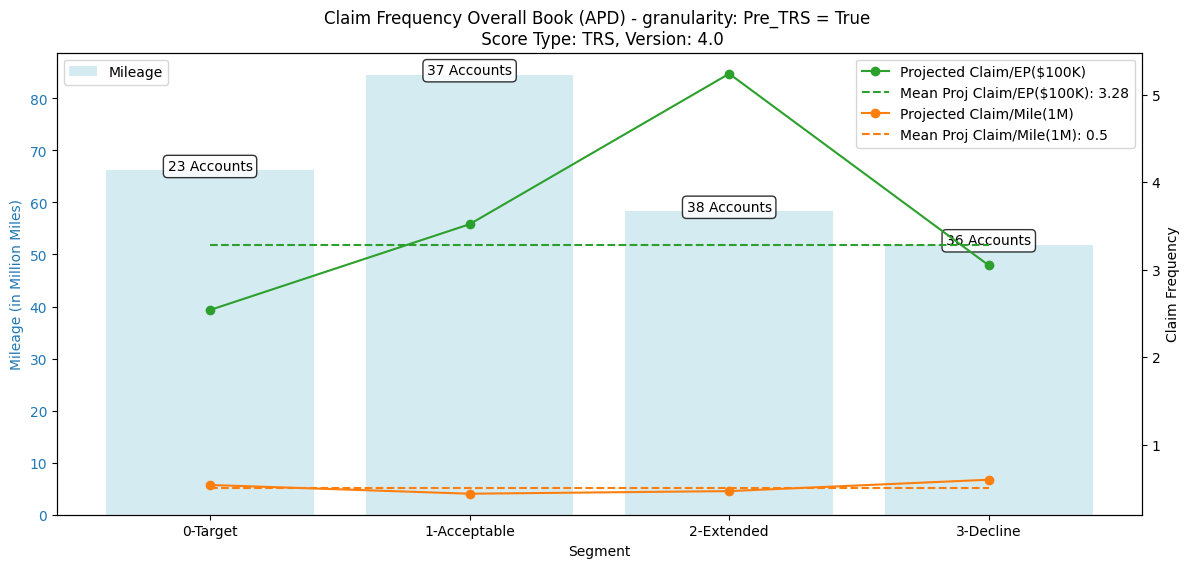

In [318]:
granularity='Pre_TRS'

analysis_data, summary = generate_summary_stats(
    eval_date=eval_date, 
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    trs_launch_date=trs_launch_date,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # print(plot_data)
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Overall Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6)
        )
        plt.show()

#### By Renewal

Generating summary stats for APD
Reading claims data for APD
(321, 15)
Length of evaluation data after merging valid app trs data: 2485


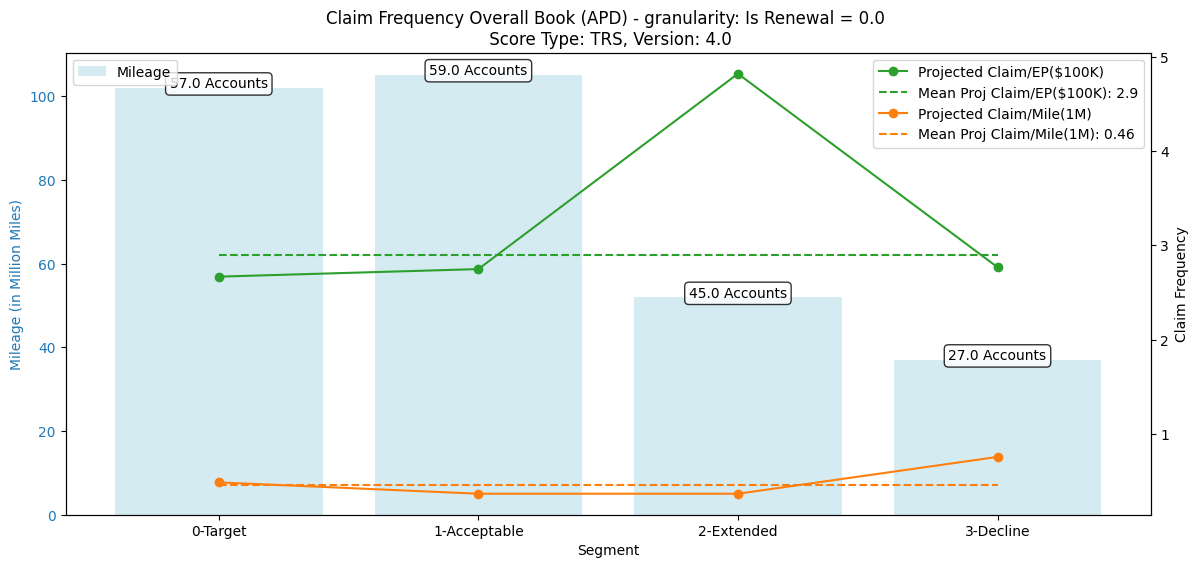

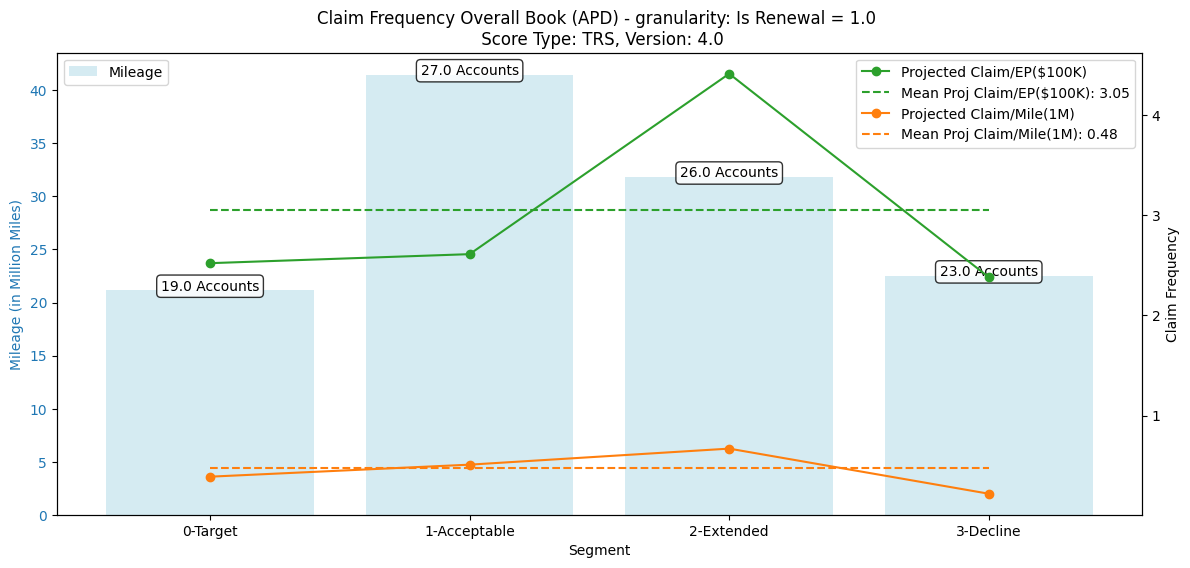

In [319]:
granularity='Is Renewal'

analysis_data, summary = generate_summary_stats(
    eval_date=eval_date, 
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    trs_launch_date=trs_launch_date,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Overall Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14,6)
        )
        plt.show()

#### By Effective Year

Generating summary stats for APD
Reading claims data for APD
(321, 15)
Length of evaluation data after merging valid app trs data: 2485


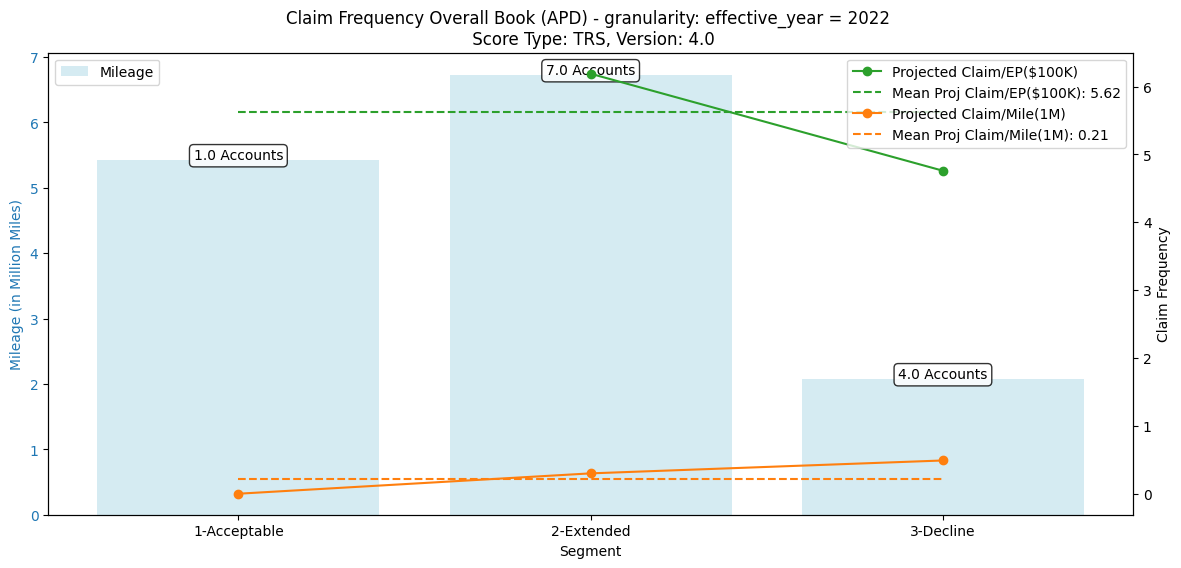

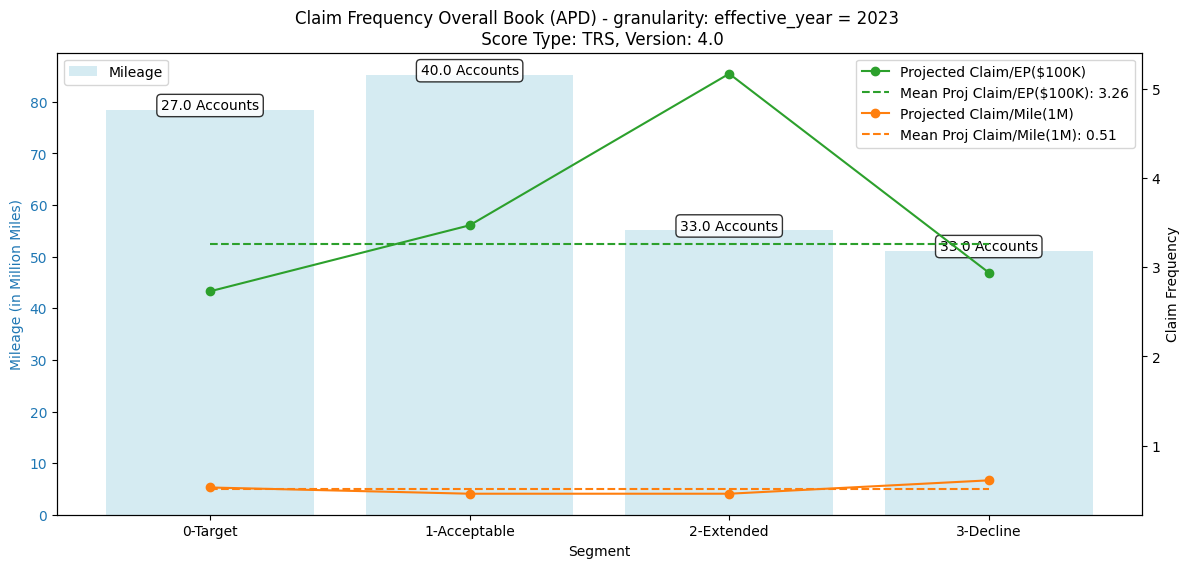

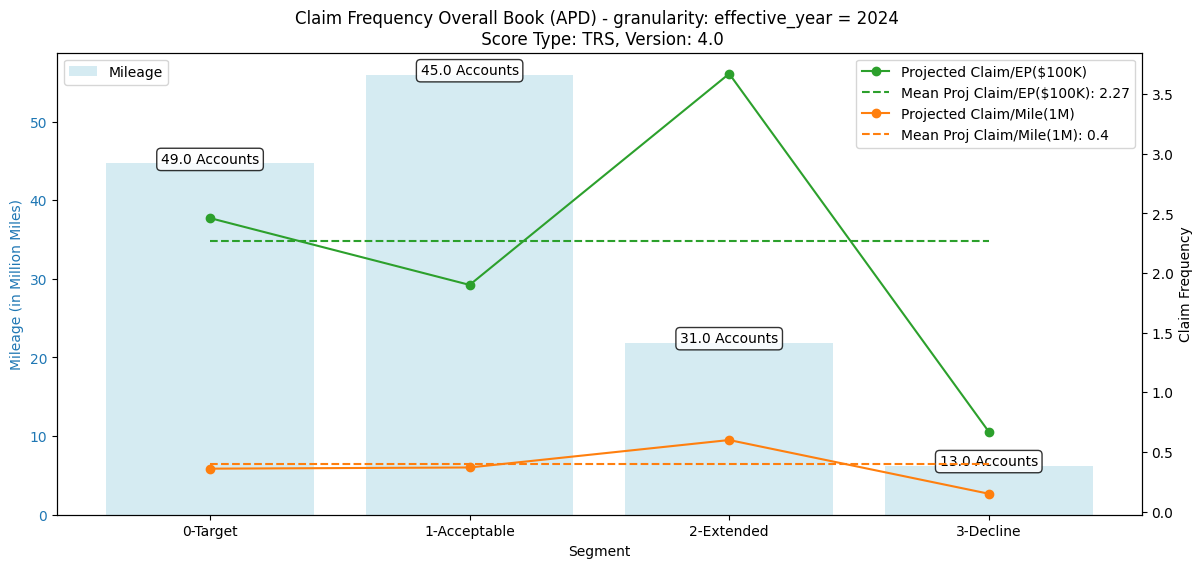

In [320]:
granularity='effective_year'

analysis_data, summary = generate_summary_stats(
    eval_date=eval_date, 
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    trs_launch_date=trs_launch_date,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Overall Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6)
        )
        plt.show()

## GPS 10 sec

In [50]:
score_type = "GPS Only 10-sec TRS"
score_version = 1.0

### AL

In [51]:
coverage_type = 'AL'

Generating summary stats for AL
Reading claims data for AL
(475, 18)
Length of evaluation data after merging valid app trs data: 3446
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 3446


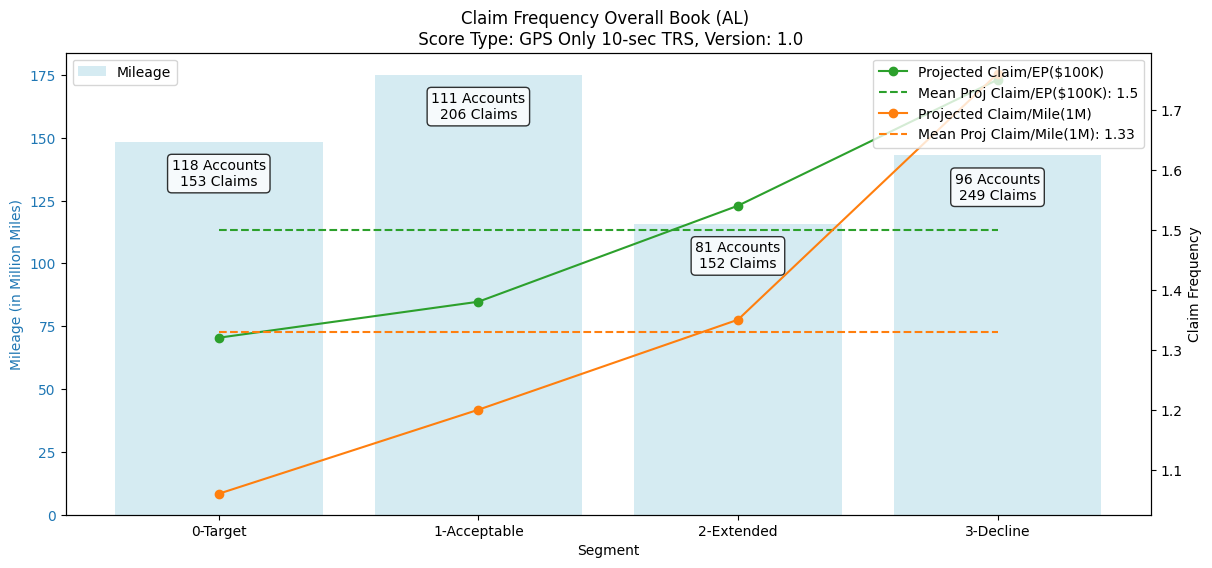

In [54]:
analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
)

plot_claim_frequency(summary, title="Claim Frequency Overall Book ({}) \n Score Type: {}, Version: {}".format(coverage_type, score_type, score_version), figsize=(14, 6), show_ep=True,)

#### Pre-Post TRS

Generating summary stats for AL
Reading claims data for AL
(475, 18)
Length of evaluation data after merging valid app trs data: 3446
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 3446


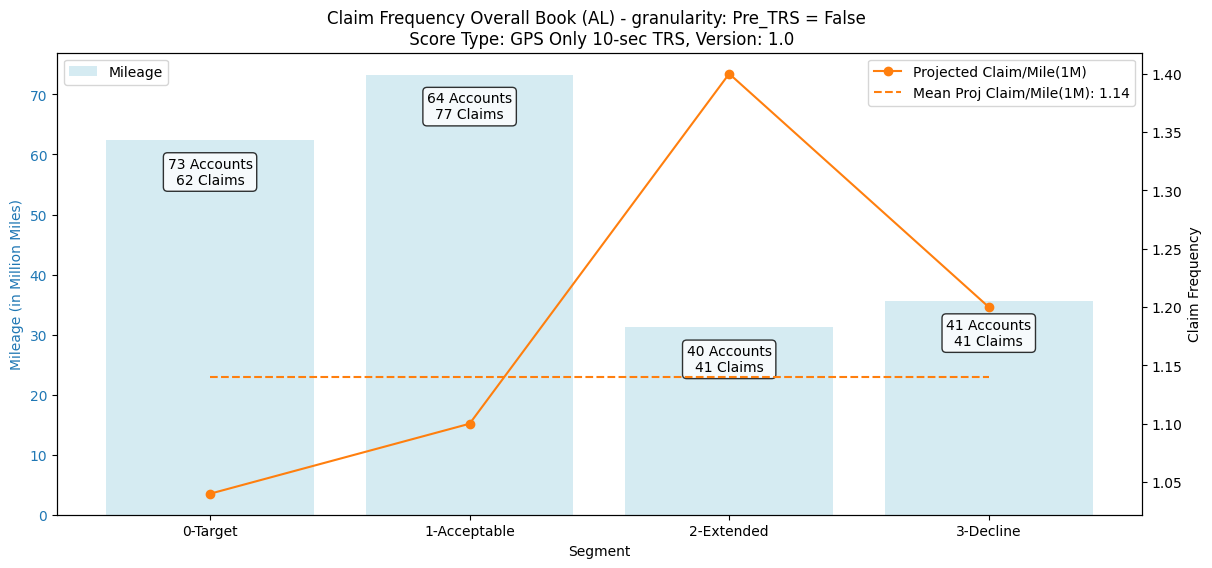

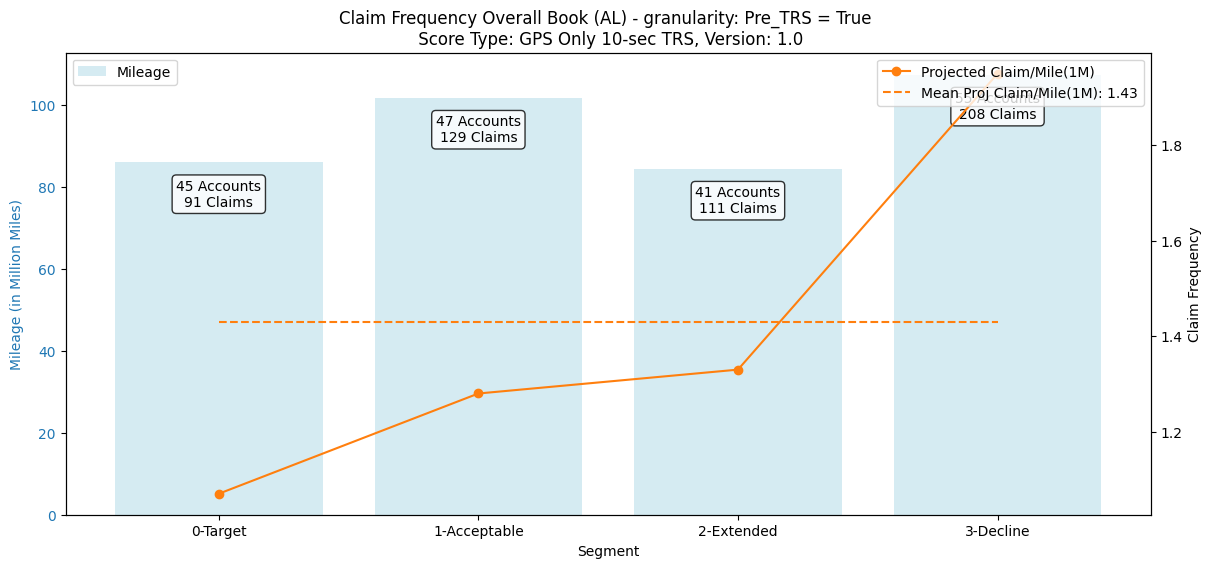

In [55]:
granularity='Pre_TRS'

analysis_data, summary = generate_summary_stats( 
    cut_off_date=cut_off_date,
    app_trs_data=bound_app_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # print(plot_data)
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Overall Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6),
            show_ep=False,
        )
        plt.show()

#### By Renewal

Generating summary stats for AL
Reading claims data for AL
(475, 18)
Length of evaluation data after merging valid app trs data: 3446
Length of vin count data: 13279
Length of evaluation data after merging vin count data: 3446


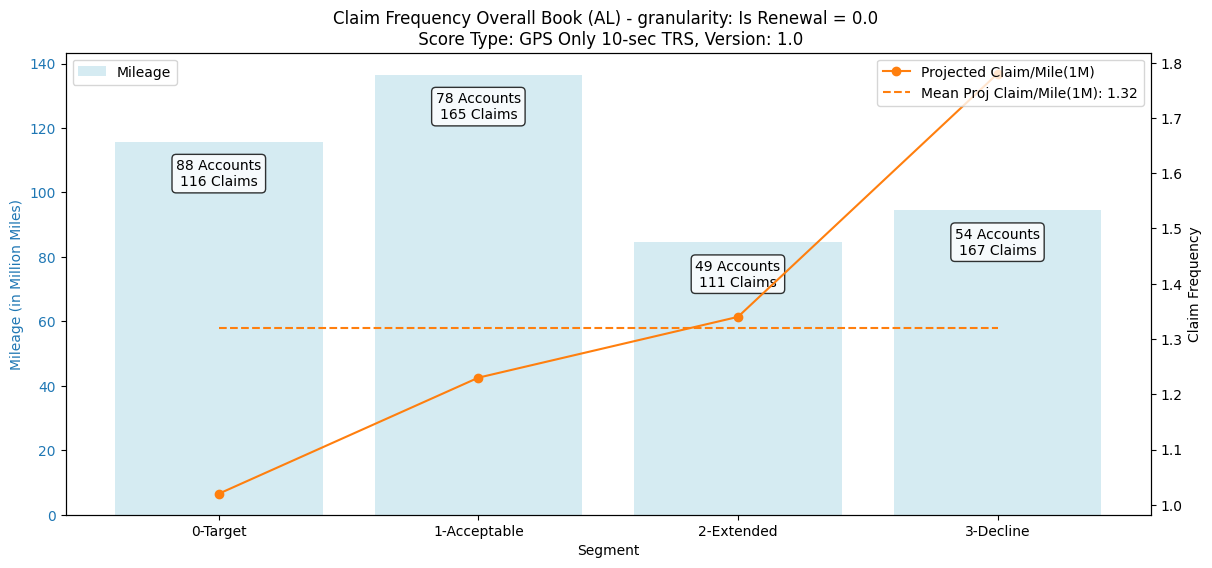

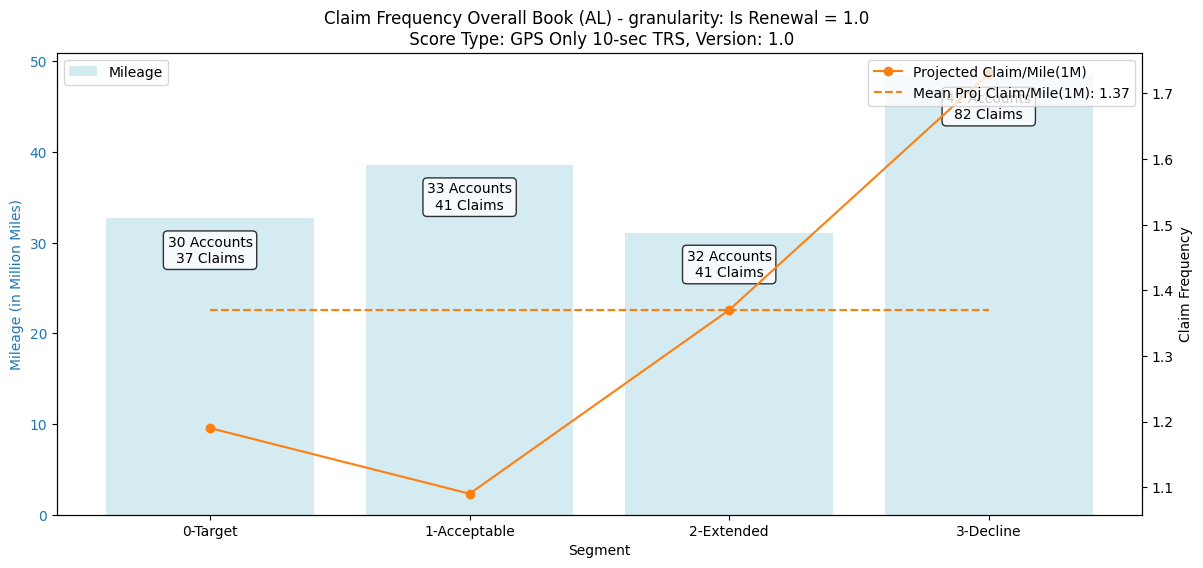

In [56]:
granularity='Is Renewal'

analysis_data, summary = generate_summary_stats(
    cut_off_date=cut_off_date,
    app_trs_data=bound_app_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # print(plot_data)
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Overall Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6),
            show_ep=False,
        )
        plt.show()

#### By Effective Year

Generating summary stats for APD
Reading claims data for APD
(321, 15)
Length of evaluation data after merging valid app trs data: 2485


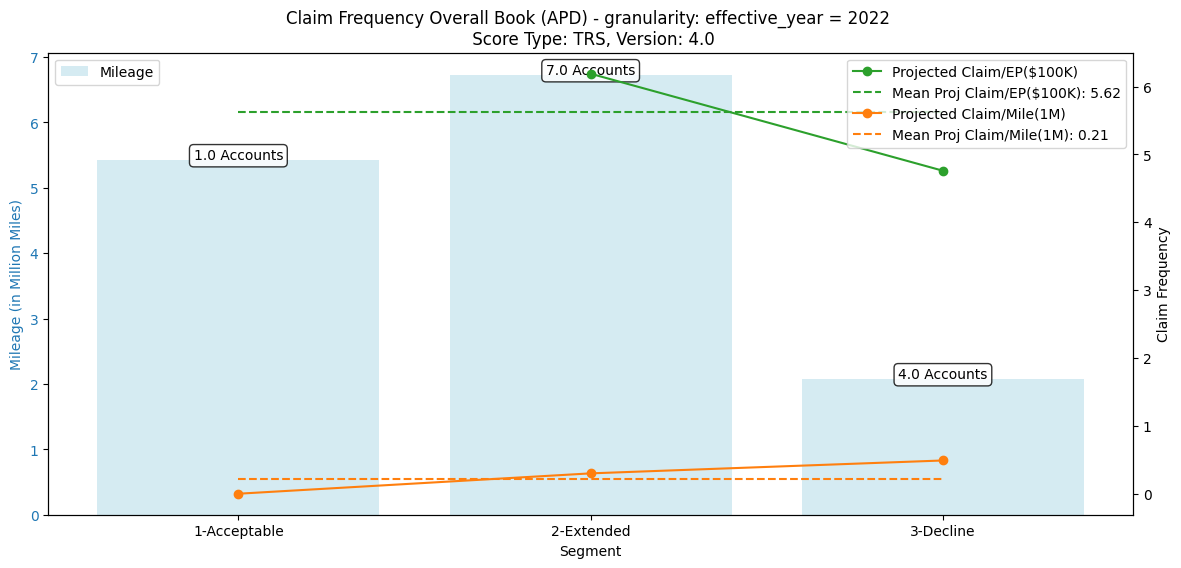

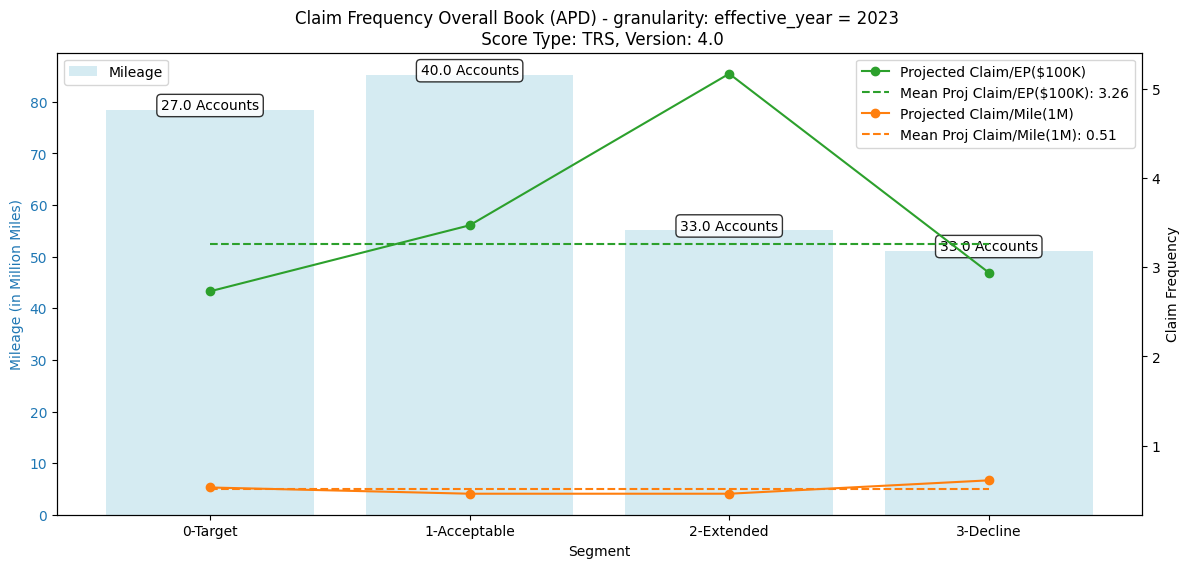

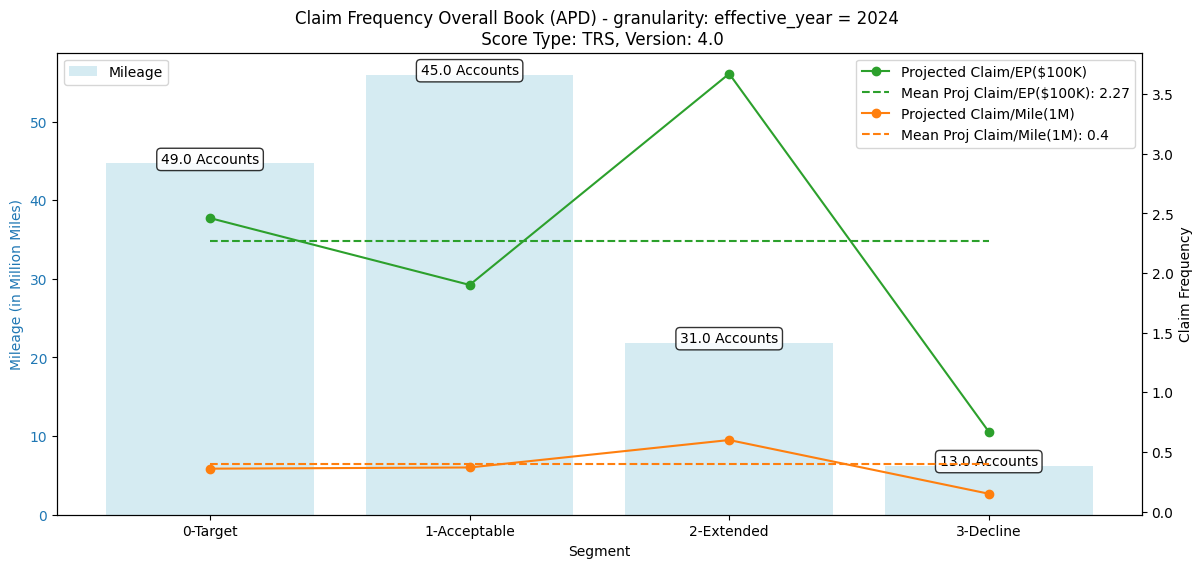

In [324]:
granularity='effective_year'

analysis_data, summary = generate_summary_stats(
    eval_date=eval_date, 
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    trs_launch_date=trs_launch_date,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Overall Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6)
        )
        plt.show()

### APD

In [299]:
coverage_type = 'APD'

Generating summary stats for APD
Reading claims data for APD
(321, 15)
Length of evaluation data after merging valid app trs data: 2485


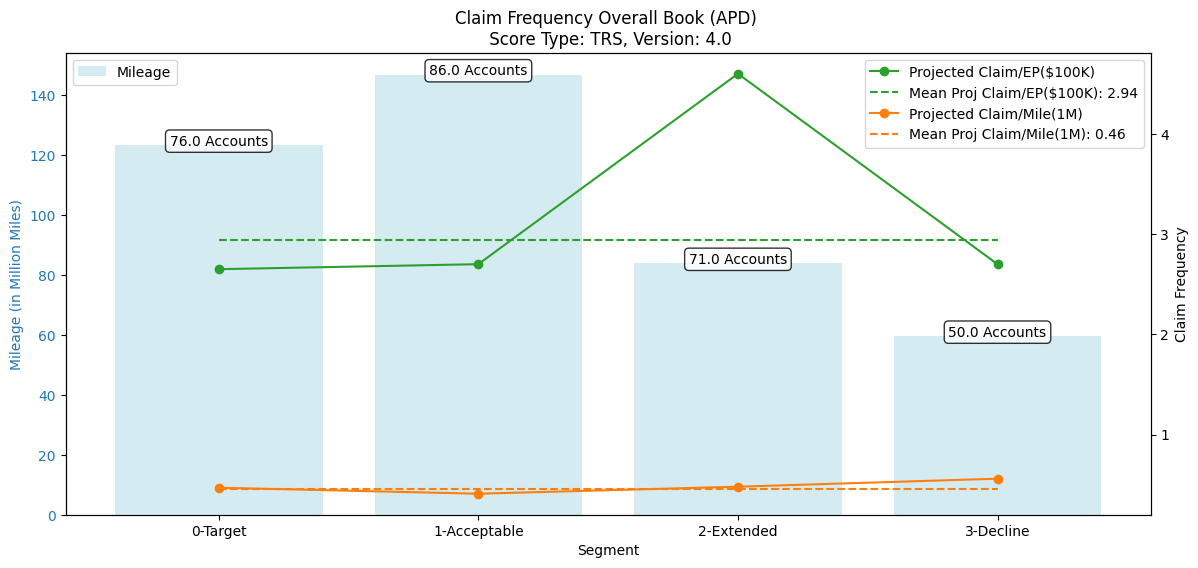

In [325]:
analysis_data, summary = generate_summary_stats(
    eval_date=eval_date, 
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    trs_launch_date=trs_launch_date,
)

plot_claim_frequency(summary, title="Claim Frequency Overall Book ({}) \n Score Type: {}, Version: {}".format(coverage_type, score_type, score_version), figsize=(14, 6))

#### Pre-Post TRS

Generating summary stats for APD
Reading claims data for APD
(321, 15)
Length of evaluation data after merging valid app trs data: 2485


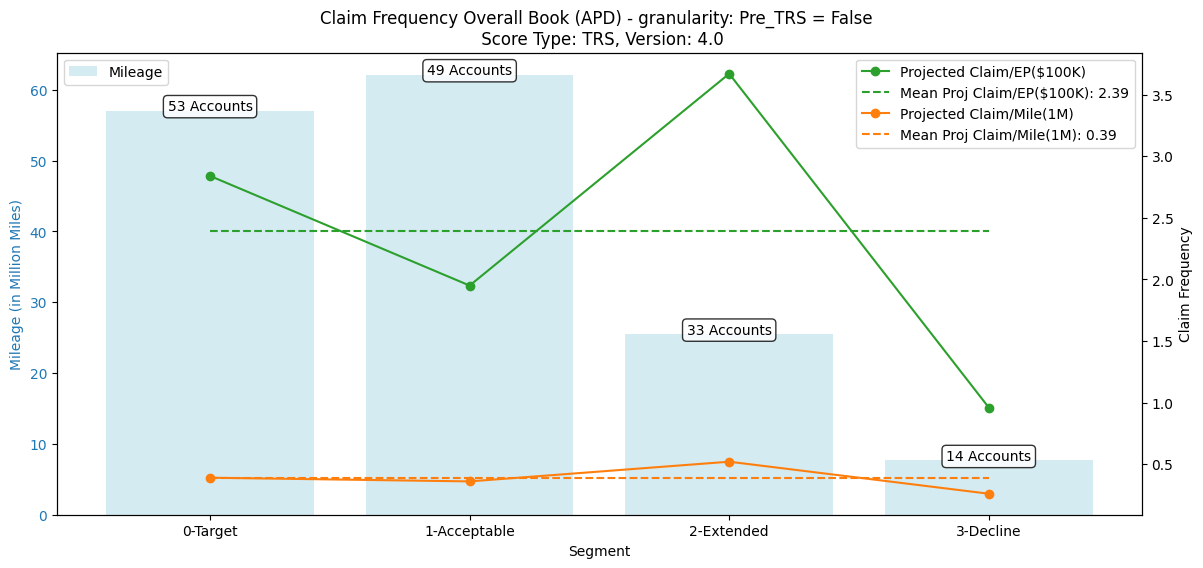

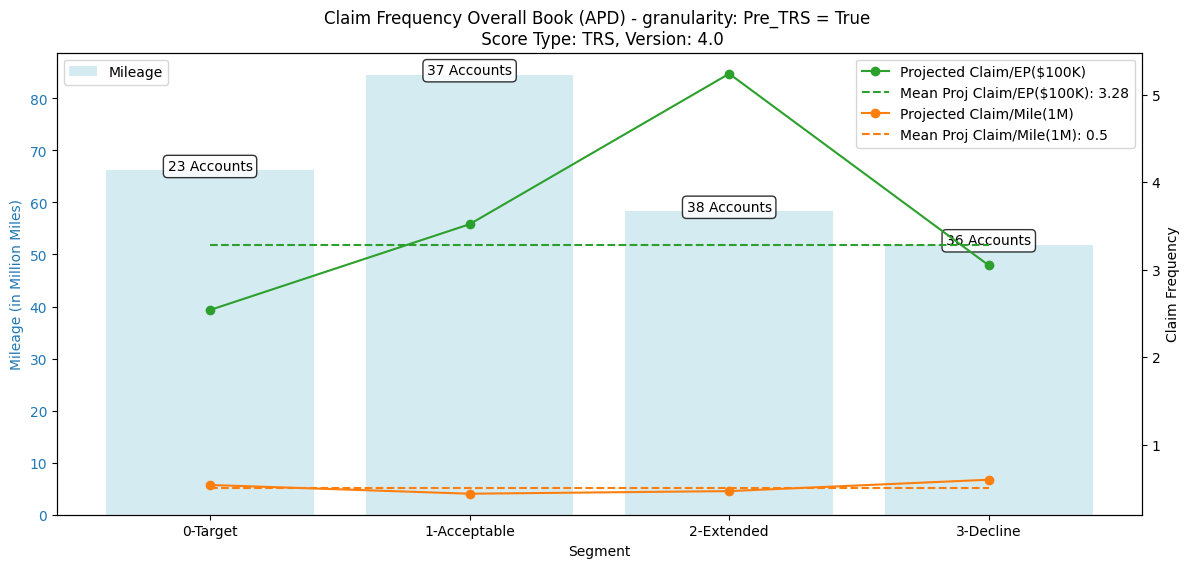

In [326]:
granularity='Pre_TRS'

analysis_data, summary = generate_summary_stats(
    eval_date=eval_date, 
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    trs_launch_date=trs_launch_date,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # print(plot_data)
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Overall Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6)
        )
        plt.show()

#### By Renewal

Generating summary stats for APD
Reading claims data for APD
(321, 15)
Length of evaluation data after merging valid app trs data: 2485


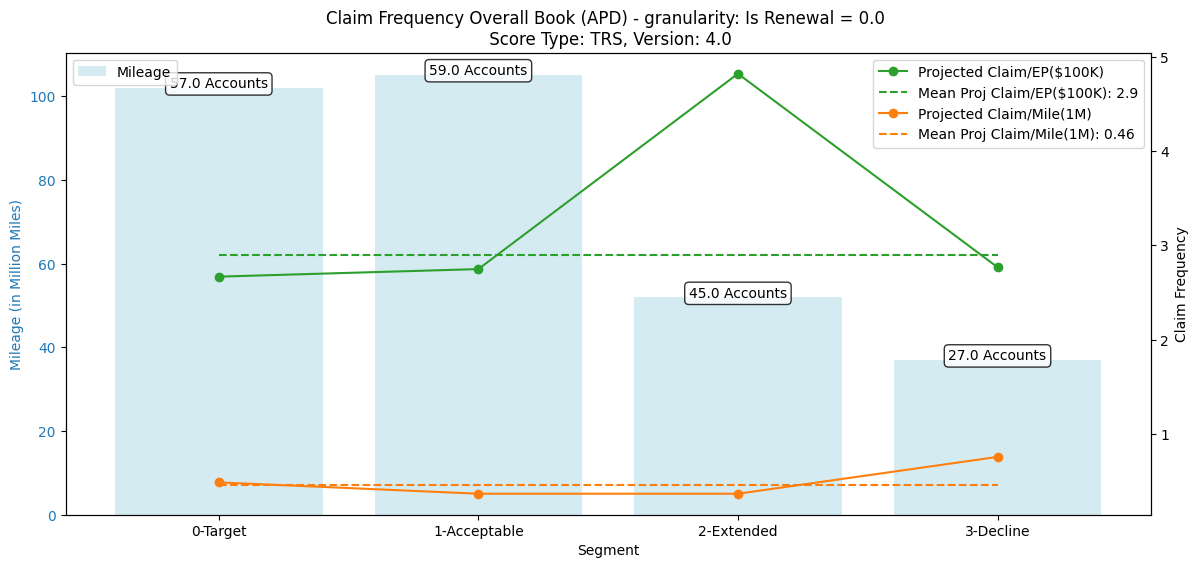

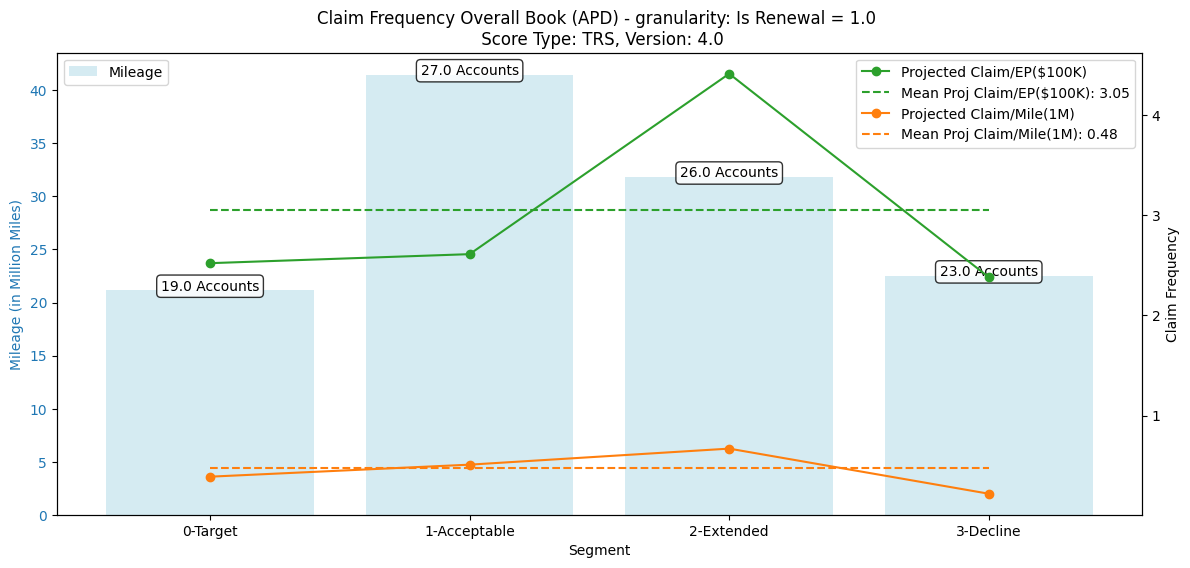

In [327]:
granularity='Is Renewal'

analysis_data, summary = generate_summary_stats(
    eval_date=eval_date, 
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    trs_launch_date=trs_launch_date,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # print(plot_data)
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Overall Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6)
        )
        plt.show()

#### By Effective Year

Generating summary stats for APD
Reading claims data for APD
(321, 15)
Length of evaluation data after merging valid app trs data: 2485


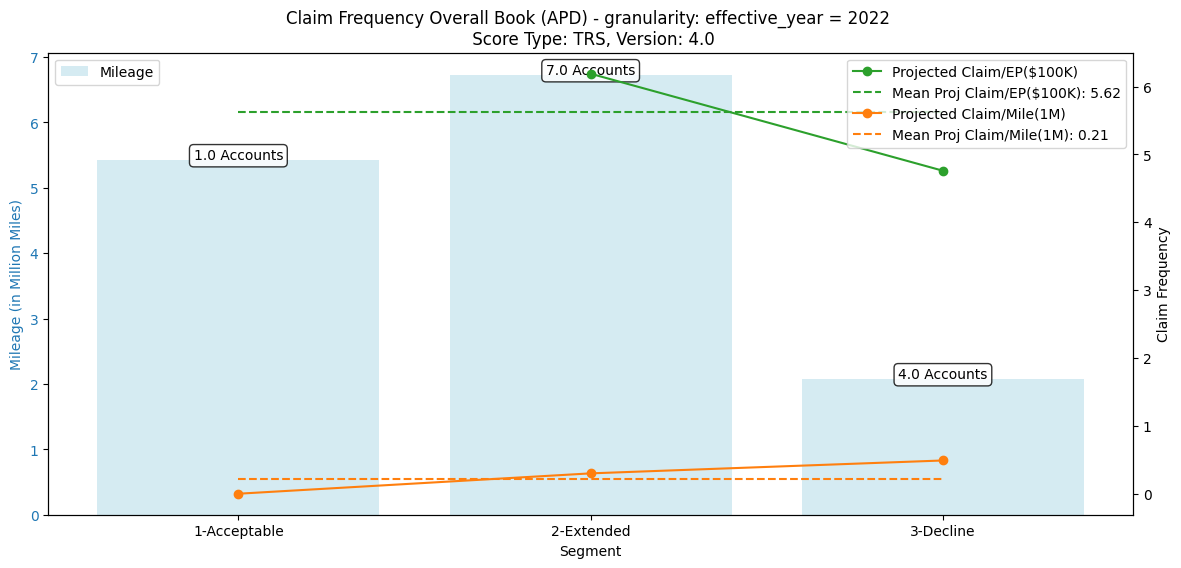

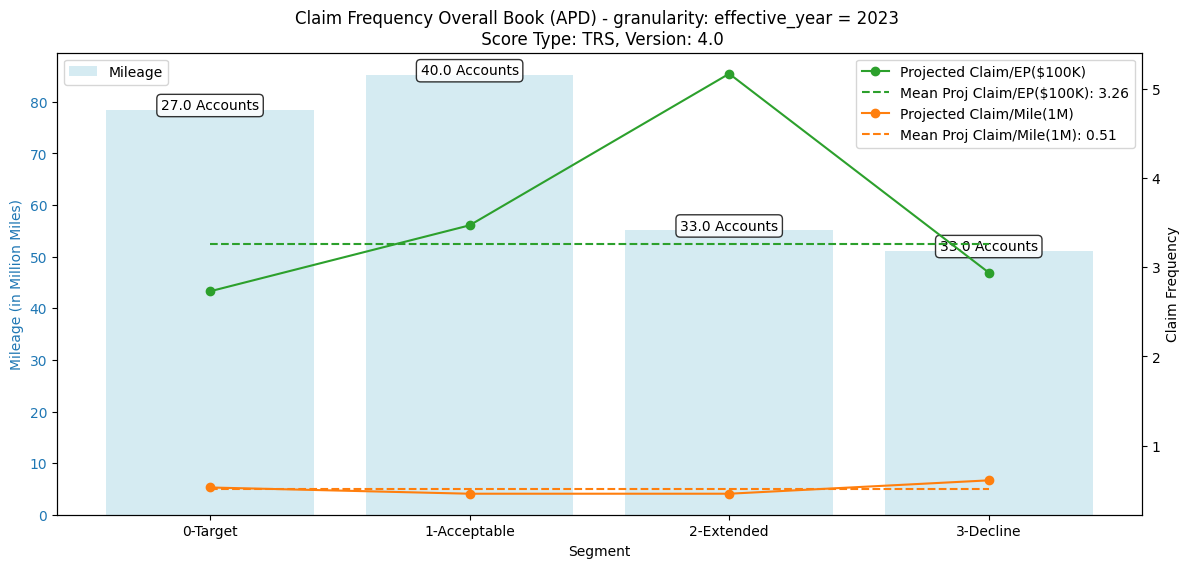

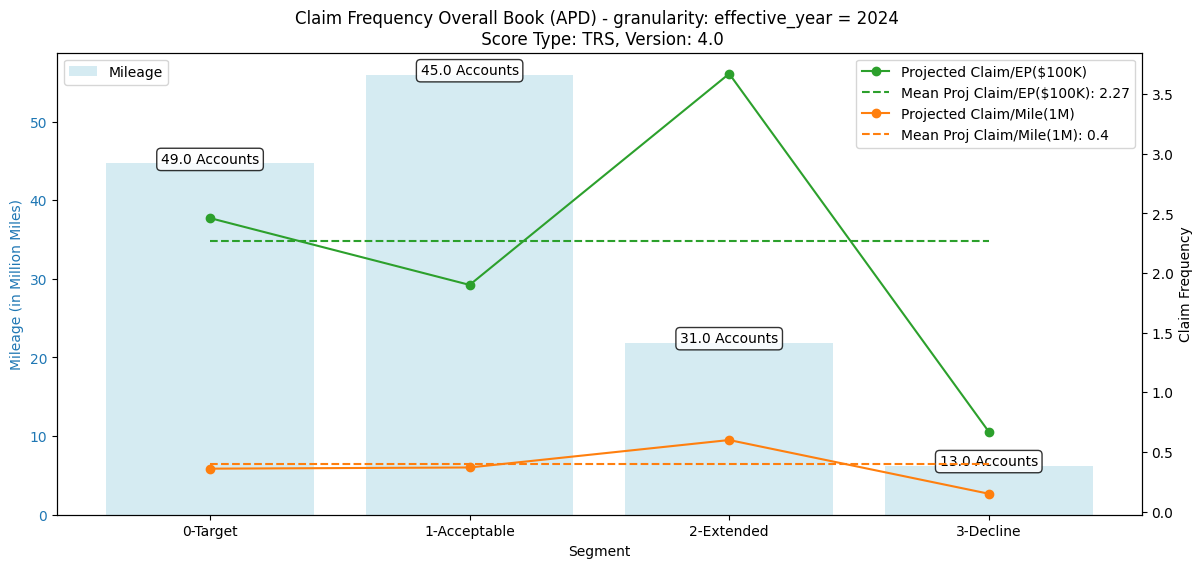

In [328]:
granularity='effective_year'

analysis_data, summary = generate_summary_stats(
    eval_date=eval_date, 
    cut_off_date=cut_off_date,
    app_trs_data=req_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    trs_launch_date=trs_launch_date,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Overall Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14, 6)
        )
        plt.show()

#### Pre-TRS By Renewal

Generating summary stats for AL
Reading claims data for AL
(188, 16)
Length of evaluation data after merging valid app trs data: 2316


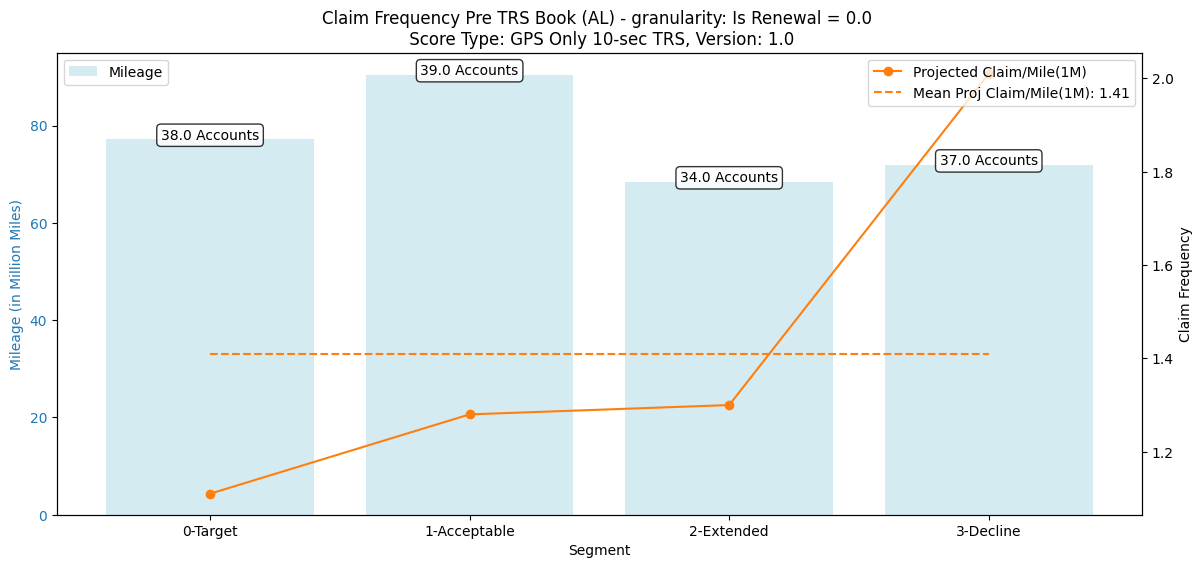

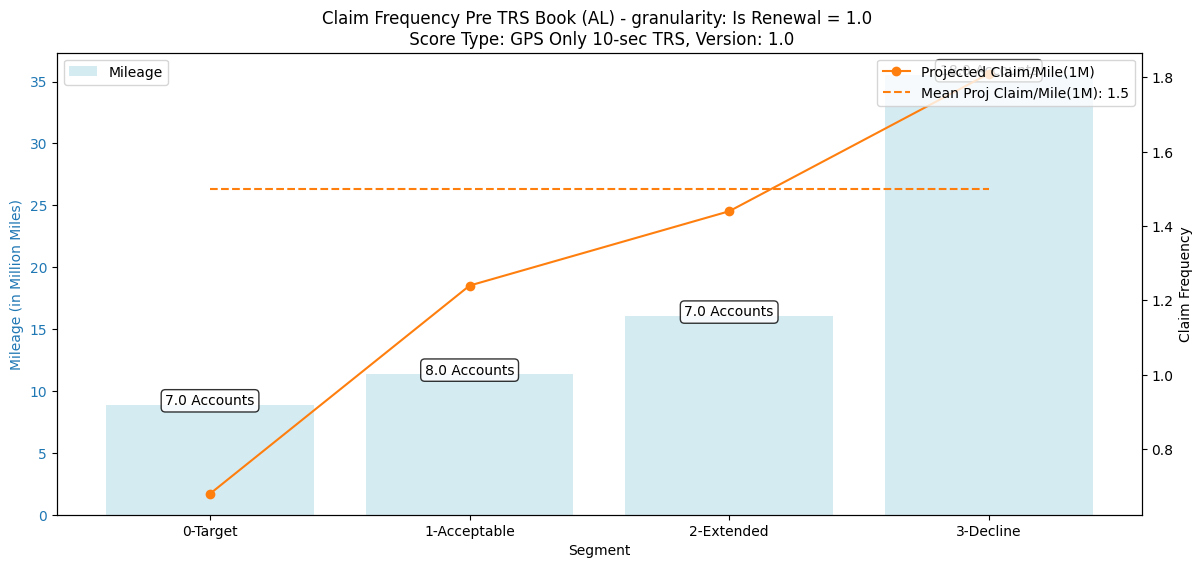

In [392]:
granularity='Is Renewal'

analysis_data, summary = generate_summary_stats(
    eval_date=eval_date, 
    cut_off_date=cut_off_date,
    app_trs_data=pre_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    trs_launch_date=trs_launch_date,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Pre TRS Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14,6),
            show_ep=False,
        )
        plt.show()

#### Post-TRS By Renewal

Generating summary stats for AL
Reading claims data for AL
(287, 16)
Length of evaluation data after merging valid app trs data: 1130


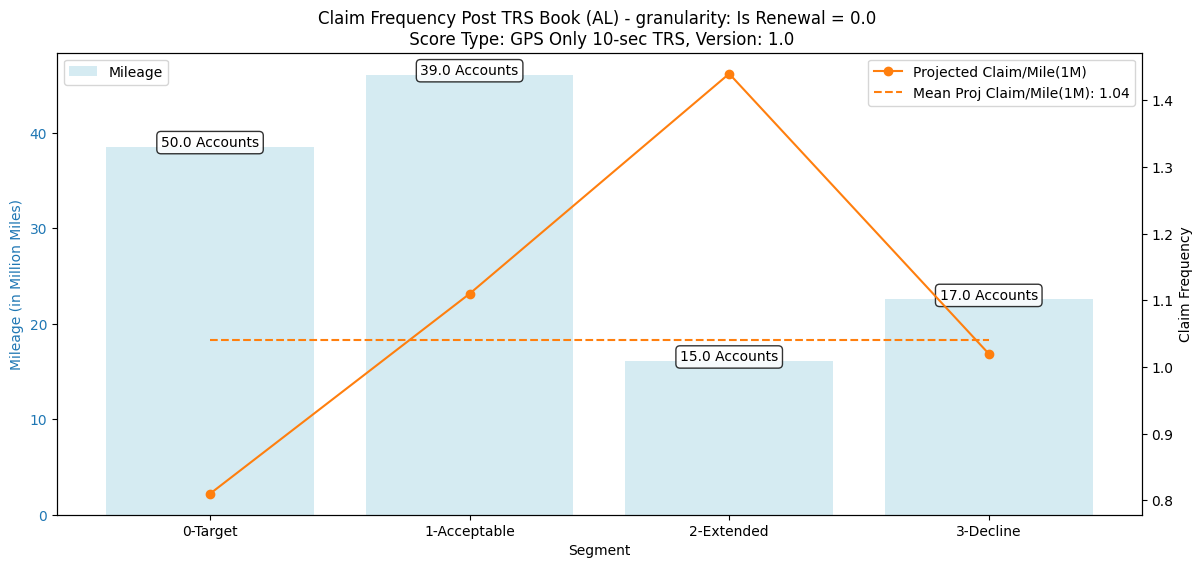

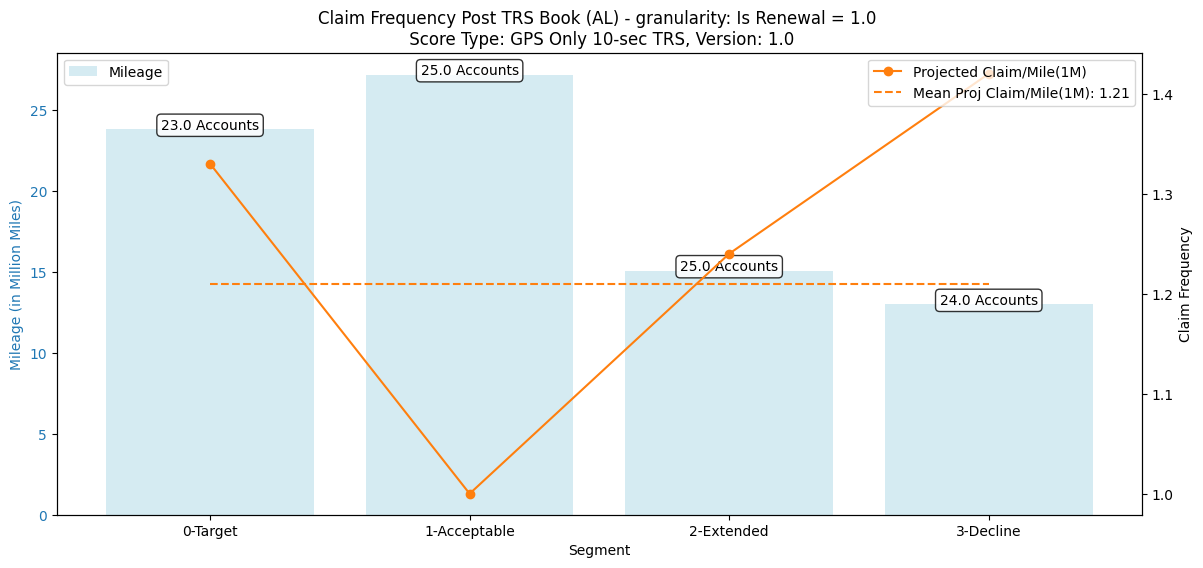

In [393]:
granularity='Is Renewal'

analysis_data, summary = generate_summary_stats(
    eval_date=eval_date, 
    cut_off_date=cut_off_date,
    app_trs_data=post_trs_data, 
    score_type=score_type, 
    score_version=score_version, 
    coverage_type=coverage_type, 
    claim_count_col=claim_count_col,
    projected_claim_col=projected_claim_col,
    trs_launch_date=trs_launch_date,
    granularity=granularity,
)

if granularity in summary.index.names:
    for val in summary.index.get_level_values(granularity).unique():
        plot_data = summary[summary.index.get_level_values(granularity) == val]
        # plt.figure(figsize=(14, 8))
        plot_claim_frequency(
            plot_data, 
            title="Claim Frequency Post TRS Book ({}) - granularity: {} = {} \n Score Type: {}, Version: {}".format(
                coverage_type, granularity, val, score_type, score_version
            ),
            figsize=(14,6),
            show_ep=False,
        )
        plt.show()

In [35]:
def get_trs_combined_data2(claims_data, app_trs_data):
    app_trs_data = app_trs_data[
        [
            'Application ID', 'Connection ID', 'Effective Date', 'Tsp Enum', 'Is Quoted', 'Is Renewal', 'Is Bound',
            'Score Type', 'Version', 'Start Date', 'End Date', 'Vin Count', 'Score', 'Days To Effective', 'Segment', 'Appetite Score'
        ]
    ]

    app_trs_data['Segment'] = app_trs_data['Segment'].map(segment_map)
    app_trs_data['Appetite Score'] = app_trs_data['Appetite Score'].map(appetite_map)
    
    print(app_trs_data.shape)
    print(claims_data.shape)
    evaluation_data = app_trs_data.merge(claims_data, how='inner', on='Application ID')
    print(f"Length of evaluation data after merging valid app trs data: {len(evaluation_data)}")
    
    evaluation_data['effective_year'] = evaluation_data['Effective Date'].dt.year
    evaluation_data['effective_month'] = evaluation_data['Effective Date'].dt.to_period('M').astype('str')
    evaluation_data['effective_quarter'] = evaluation_data['Effective Date'].dt.to_period('Q').astype('str')
    evaluation_data['effective_year_half'] = (
        evaluation_data['Effective Date'].dt.year.astype(str) + "H" + evaluation_data['Effective Date'].dt.month.gt(6).add(1).astype(str)
    )

    return evaluation_data

claims_data = get_projected_claims_data(coverage_type='AL')
trs_combined_data = get_trs_combined_data2(claims_data, bound_app_trs_data)

Reading claims data for AL
(1941, 16)
(4876, 7)
Length of evaluation data after merging valid app trs data: 14608


In [39]:
trs_combined_data.to_csv(f"{data_path}/trs_combined_data.csv", index=False)